<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/Finishing-touches/2.2_response_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 2.2 Aggregation and Response Synthesis (Post-Retrieval) -<br> Merging retrieved results and applying advanced post-retrieval techniques

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** This step deals with post-retrieval processing. After an initial set of candidate chunks is retrieved, techniques are applied to refine these results before they are passed to the LLM. The primary focus is on re-ranking, using sophisticated models to reorder the retrieved chunks based on relevance.

# 1.0 Loading Data and functions from previous stage

## 1.1 Setup of the environment

### Installations and loading of packages

In [ ]:
!pip install torch torchvision torchaudio

In [2]:
import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    # The model will automatically be placed on the GPU
else:
    print("GPU is not available. Running on CPU.")

GPU is available: NVIDIA L4


In [ ]:
!pip install langchain langchain_groq faiss_cpu FlagEmbedding

In [ ]:
!python -m pip install cohere --upgrade

Below the necessary libraries are installed and loaded into the environment.

In [5]:
import os
import re
import json
import asyncio
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pickle
import faiss
from typing import Optional, List
from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from FlagEmbedding import FlagReranker
from google.colab import userdata

In [6]:
import nest_asyncio
nest_asyncio.apply()

from typing import List, Literal
from pydantic import BaseModel, Field
from openai import OpenAI

### Setting seeds and mounting Google Drive storage folder

In [7]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

### Check properties of environment

In [10]:
!nvidia-smi

Sat Jun 14 10:21:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.6.2.0.38

## 1.2 Loading the datasets

In [ ]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [ ]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [ ]:
# Run this cell if working locally
df = pd.read_csv('data/Stage2-02-chunked-dataset.csv')
with open('data/Stage2-08-q-a-file-with-relevancy.pkl', 'rb') as f:
	Q_A_ground_thruth_relevancy_dict = pickle.load(f)

	filename = 'data/Stage3-01-precalc-retrieved-chunks.pkl'
	with open(filename, 'rb') as f:
		precalc_retrieved_chunks = pickle.load(f)
	print(f"Dictionary loaded from {filename}:")

# load files in local computer and api from data .env
from dotenv import dotenv_values

env_vars = dotenv_values('data/.env')
OPENAI_API_KEY = env_vars.get('OPENAI_API_KEY', None)
print(f"Loaded OPENAI_API_KEY: {'***' if OPENAI_API_KEY else 'Not found'}")

## 1.3 Build Dense Vector Store and define Retrievers

In [ ]:
# Build FAISS Index for Multilingual Dense Retrieval
# Uses Sentence-BERT (distiluse-base-multilingual-cased-v1) for multilingual embeddings (English & German supported)
def build_faiss_index(df, model_name='sentence-transformers/distiluse-base-multilingual-cased-v1'):
    model = SentenceTransformer(model_name)
    # Convert all chunk texts to embeddings (normalized for cosine similarity)
    embeddings = model.encode(df['chunk_text'].tolist(), convert_to_numpy=True, normalize_embeddings=True)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # Inner product on normalized vectors = cosine similarity
    index.add(embeddings)
    return model, index, embeddings, df.reset_index(drop=True)

In [ ]:
# Multilingual Semantic Retrieval (English or German query)
def retrieve_dense_faiss(query, model, index, df, top_k=5):
    # Query can be in English or German (model is multilingual)
    query_vec = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, indices = index.search(query_vec, top_k)
    results = df.iloc[indices[0]].copy()
    results['score'] = scores[0]
    return results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

# Build FAISS index only once (if not already built)
dense_model, faiss_index, dense_embeddings, dense_df = build_faiss_index(df)

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
test_query = "Who is the rector of ETH"
print("Query:", test_query)
dense_results = retrieve_dense_faiss(test_query, dense_model, faiss_index, dense_df)
display(dense_results)

Query: Who is the rector of ETH


,unique_chunk_id,chunk_text,score,title
15758,2547_00,ETH is one of the world’s leading technical un...,0.494082,Where next for eth
10407,1289_01,Was macht der Direktor des ETH-Zentrums Singap...,0.477289,Wer in singapur forschen will soll sich jetzt ...
15177,2345_02,What does this mean for members of ETH who app...,0.474332,Ombudspersons trio is complete
12798,1917_06,## Wie die ETH zu ihrer Rektorin oder ihrem Re...,0.468042,Guenther dissertori als rektor eth zuerich
19189,3205_02,How relevant is it whether ETH acts as the ove...,0.462756,Roland siegwart why the nccrs are so important...


In [ ]:
# Define OpenAI Api Key
import openai
from google.colab import userdata

api_key = userdata.get('openai_advAI')

In [ ]:
# Pydantic Model for LLM Output
class GeneratedHydeDocuments(BaseModel):
    documents: List[str] = Field(
        description="A list of three diverse, concise, and relevant hypothetical documents that comprehensively answer the original query.",
        min_length=3,
        max_length=3
    )

In [ ]:
# OpenAI Function for Generating Variations
def get_openai_client(api_key: str = None):
    """Initializes and returns an OpenAI client."""
    return OpenAI(api_key=api_key)

def generate_variations_openai(
    original_query: str,
    variation_type: Literal["queries", "hyde_documents"],
    num_variations: int = 3,
    llm_model: str = "gpt-4o",
    client: OpenAI = None,
    api_key: str = None
) -> List[str]:
    """
    Generates multiple query variations or hypothetical documents using OpenAI LLM.
    """
    if client is None:
        client = get_openai_client(api_key=api_key) # Use passed api_key

    if num_variations != 3:
        # This warning is good, Pydantic models enforce 3.
        print(f"Warning: Pydantic models are set for 3 variations. Generating {num_variations} might conflict if not 3.")
    json_structure_example_hyde = f"""
Your response MUST be a JSON object with a single key "documents".
The value of "documents" MUST be a list of exactly {num_variations} strings, where each string is a hypothetical document.
Example for {num_variations} variations:
{{
  "documents": [
    "hypothetical document text 1...",
    "hypothetical document text 2...",
    "hypothetical document text 3..."
  ]
}}
"""
    if variation_type == "hyde_documents":
        type_desc = "hypothetical documents. Each document should be a concise, ideal answer to the original query, rich in relevant keywords and concepts, and diverse from the others."
        json_structure_guidance = json_structure_example_hyde
    else:
        raise ValueError("variation_type must be 'queries' or 'hyde_documents'")

    system_prompt_template = """
You are an expert in search query optimization and information retrieval.
Your primary task is to generate exactly {num_variations} diverse and effective {type_description} based on the original user query.
These variations are crucial for retrieving the most relevant documents from a corpus.

{json_guidance}

Ensure your output strictly adheres to this JSON structure. Do not include any other text, explanations, or apologies.
"""
    system_prompt = system_prompt_template.format(
        num_variations=num_variations,
        type_description=type_desc,
        json_guidance=json_structure_guidance
    )
    user_prompt = f"Original Query: '{original_query}'"

    try:
        response = client.chat.completions.create(
            model=llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_object"},
            temperature=0.6,
        )

        json_response_str = response.choices[0].message.content

        parsed_output = GeneratedHydeDocuments.model_validate_json(json_response_str)
        return parsed_output.documents

    except Exception as e:
        print(f"Error calling OpenAI or parsing response: {e}")
        # Fallback to simple placeholder variations in case of API error
        # Using a more distinct fallback to differentiate from potential successful but simple LLM output
        error_prefix = "ERROR_FALLBACK_"
        return [f"{error_prefix}Hypothetical document for {original_query} - version {i+1}. This document details..." for i in range(num_variations)]

In [ ]:
test_query = "Is ETH developing an AI system to develop treatments in the field of medicine?"
print("Query:", test_query)
print("HyDE Documents:")
pprint.pprint(generate_variations_openai(test_query, variation_type="hyde_documents", api_key=api_key))

Query: Is ETH developing an AI system to develop treatments in the field of medicine?
HyDE Documents:
['ETH Zurich, a leading university in technology and natural sciences, is '
 'actively involved in the intersection of artificial intelligence and '
 'medicine. The institution has launched several research initiatives aimed at '
 'utilizing AI to develop innovative treatments in the medical field. These '
 'projects focus on areas such as drug discovery, personalized medicine, and '
 'predictive diagnostics, leveraging machine learning algorithms to analyze '
 'complex biological data and expedite the development of new therapies.',
 'Recent developments at ETH Zurich indicate a strong commitment to '
 'integrating artificial intelligence into medical research. Faculty members '
 'and researchers at ETH are pioneering efforts to create AI-driven systems '
 'that can aid in the development of medical treatments. This includes '
 'collaborations with pharmaceutical companies and healthc

In [ ]:
def min_max_normalize(scores_series):
    min_score = scores_series.min()
    max_score = scores_series.max()

    if max_score == min_score:
        return pd.Series([0.0 if min_score == 0 else 1.0] * len(scores_series),
                         index=scores_series.index, dtype=float)

    normalized_scores = (scores_series - min_score) / (max_score - min_score)
    return normalized_scores

def normalize_scores(df_results, score_column='score'):
    """
    Normalizes scores in a DataFrame column to a 0-1 range.
    Uses the min_max_normalize function.
    """
    df_results[score_column] = min_max_normalize(df_results[score_column])
    return df_results

In [ ]:
def retrieve_dense_faiss_hyde_multi(query, model, dense_embeddings, dense_df, top_k=5):
    if dense_embeddings is None or dense_df.empty:
        return pd.DataFrame(columns=['unique_chunk_id', 'chunk_text', 'score', 'title'])

    hyde_documents = generate_variations_openai(query, variation_type="hyde_documents",
                                                api_key=api_key, num_variations=3)
    total_scores = np.zeros(len(dense_df))

    for hyde_doc_text in hyde_documents:
        hyde_vec = model.encode([hyde_doc_text], convert_to_numpy=True, normalize_embeddings=True)
        current_scores = (hyde_vec @ dense_embeddings.T).flatten()
        total_scores += current_scores

    num_docs = len(hyde_documents)
    avg_scores_values = total_scores / num_docs
    avg_scores = pd.Series(avg_scores_values, index=dense_df.index)

    normalized_scores = min_max_normalize(avg_scores)

    results_df = dense_df.copy()
    results_df['score'] = normalized_scores

    top_results = results_df.sort_values('score', ascending=False).head(top_k)
    return top_results[['unique_chunk_id', 'chunk_text', 'score', 'title']]

In [ ]:
def retrieve_hybrid_standard_dense_plus_dense_hyde(
    query: str,
    dense_model,
    dense_df: pd.DataFrame,
    faiss_index,
    dense_embeddings,
    # Retrieval parameters
    top_k: int = 5,      # Final number of chunks to return
    weight_standard_dense: float = 0.3,
    weight_dense_hyde: float = 0.7
):
    """
    Retrieves and combines documents using Standard Dense and Dense HyDE retrieval.

    Args:
        query (str): The search query.
        dense_model: The SentenceTransformer model (used by both retrievers).
        dense_df: DataFrame of documents (used by both retrievers).
        faiss_index: FAISS index for standard dense retrieval.
        dense_embeddings: Numpy array of pre-computed document embeddings for Dense HyDE.
        top_k (int): The final number of documents to return.
        weight_standard_dense (float): Weight for the standard dense scores.
        weight_dense_hyde (float): Weight for the Dense HyDE scores.

    Returns:
        pd.DataFrame: DataFrame of the top_k retrieved documents with their combined scores.
    """
    intermediate_top_k = max(20, 4 * top_k)

    # 1. Retrieve with Standard Dense Search
    std_dense_results_raw = retrieve_dense_faiss(
        query, dense_model, faiss_index, dense_df, top_k=intermediate_top_k)

    std_dense_results_normalized = normalize_scores(std_dense_results_raw.copy(), score_column='score')
    std_dense_results_normalized['score'] *= weight_standard_dense
    std_dense_results_final = std_dense_results_normalized[['unique_chunk_id', 'chunk_text', 'title', 'score']].set_index('unique_chunk_id')

    # 2. Retrieve with Dense HyDE
    dense_hyde_results_raw = retrieve_dense_faiss_hyde_multi(
        query, dense_model, dense_embeddings, dense_df, top_k=intermediate_top_k)

    dense_hyde_results_normalized = normalize_scores(dense_hyde_results_raw.copy(), score_column='score')
    dense_hyde_results_normalized['score'] *= weight_dense_hyde
    dense_hyde_results_final = dense_hyde_results_normalized[['unique_chunk_id', 'chunk_text', 'title', 'score']].set_index('unique_chunk_id')

    # 3. Combine results
    combined_df = pd.concat(
        [std_dense_results_final.add_suffix('_std_dense'), dense_hyde_results_final.add_suffix('_dense_hyde')],
        axis=1,
        join='outer'
    )

    combined_df['score_std_dense'] = combined_df['score_std_dense'].fillna(0)
    combined_df['score_dense_hyde'] = combined_df['score_dense_hyde'].fillna(0)
    combined_df['final_score'] = combined_df['score_std_dense'] + combined_df['score_dense_hyde']
    combined_df['chunk_text'] = combined_df['chunk_text_std_dense'].combine_first(combined_df['chunk_text_dense_hyde'])
    combined_df['title'] = combined_df['title_std_dense'].combine_first(combined_df['title_dense_hyde'])

    combined_df = combined_df.reset_index().rename(columns={'index': 'unique_chunk_id'})

    # 4. Sort by the new combined score and take the final top_k
    final_results = combined_df.sort_values(by="final_score", ascending=False).head(top_k)

    # Ensure all required columns are present in the final output
    required_cols = ['unique_chunk_id', 'chunk_text', 'title', 'score']
    output_df = pd.DataFrame(columns=required_cols) # Initialize with correct columns
    for col in required_cols:
        if col == 'score':
            # Ensure final_score is present or default to an empty float Series
            output_df[col] = final_results.get('final_score', pd.Series(dtype=float if final_results.empty else final_results['final_score'].dtype))
        else:
            # Ensure other columns are present or default to an empty object Series
             output_df[col] = final_results.get(col, pd.Series(dtype=object if final_results.empty else final_results.get(col, pd.Series(dtype=object)).dtype))

    output_df['chunk_text'] = output_df['chunk_text'].fillna("N/A")
    output_df['title'] = output_df['title'].fillna("N/A")
    output_df['score'] = output_df['score'].fillna(0.0)


    return output_df[['unique_chunk_id', 'chunk_text', 'title', 'score']]

In [ ]:
model_name = "sentence-transformers/distiluse-base-multilingual-cased-v1"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dense_model = SentenceTransformer(model_name, device=device)

In [ ]:
# The query you want to use for the hybrid search
query = "Is ETH developing an AI system to develop treatments in the field of medicine?"

print(f"Performing hybrid search (Standard Dense + Dense HyDE) for query: '{query}'")

hybrid_results_dense_plus_hyde = retrieve_hybrid_standard_dense_plus_dense_hyde(
    query=query,
    # Shared Dense components
    dense_model=dense_model,
    dense_df=dense_df,
    # Standard Dense specific
    faiss_index=faiss_index,
    # Dense HyDE specific
    dense_embeddings=dense_embeddings,
    # Retrieval parameters
    top_k=5,
)

print("\nHybrid Retrieval Results (Standard Dense + Dense HyDE):")
display(hybrid_results_dense_plus_hyde)

Performing hybrid search (Standard Dense + Dense HyDE) for query: 'Is ETH developing an AI system to develop treatments in the field of medicine?'

Hybrid Retrieval Results (Standard Dense + Dense HyDE):


,unique_chunk_id,chunk_text,title,score
18,4220_08,## “Artificial intelligence for Switzerland” s...,New app unmasks forged documents,0.713245
20,4194_06,## “Artificial Intelligence for Switzerland” s...,Ai designs new drugs based on protein structures,0.572954
22,4223_11,## “Artificial intelligence for Switzerland” s...,Climate friendly renovations using straw and hemp,0.544244
21,4157_13,## “Artificial intelligence for Switzerland” s...,Ai reality lags the hype in swiss tech industries,0.544244
23,1334_02,Für die ETH Zürich ist aber klar: Moderne medi...,Gemeinsam fuer die medizin der zukunft,0.325832


## 1.4 Prepare retrieved chunks for the different questions

To have comparable results we prepare the retrieved chunks for the questions from the Q-A dataset.

We will store the string of the questions as the keys and the returned dataframes from the retrieval as the corresponding values. With this setup we can utilize the query string in a function input and access the retrieved chunks (arranged in a dataframe) by selecting from the dictionary.

We return the 100 most relevant chunks in this initial retrieval.

In [ ]:
precalc_retrieved_chunks = dict()

In [ ]:
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
    query = data["question"]

    print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")

    retrieved_df = retrieve_hybrid_standard_dense_plus_dense_hyde(
        query = query, dense_model = dense_model, dense_df = dense_df,
        faiss_index = faiss_index, dense_embeddings = dense_embeddings,
        top_k = 100, weight_standard_dense = 0.3, weight_dense_hyde = 0.7)
    retrieved_df.reset_index(drop=True, inplace=True)
    display(retrieved_df.head(2))
    precalc_retrieved_chunks[query] = retrieved_df.copy()


Q1: Who was president of ETH in 2003?


,unique_chunk_id,chunk_text,title,score
0,3947_09,While ETH Zurich has always had an open and in...,A grounded globetrotter,0.861710
1,3795_08,"ETH President Ralph Eichler, who is handing ov...",Encouraging more critical opinion,0.616356



Q2: Who were the rectors of ETH between 2017 and 2022?


,unique_chunk_id,chunk_text,title,score
0,0269_00,Sarah Springman war 18 Jahre Professorin für G...,Die rektorin der herzen wird emeritiert globe,0.703867
1,4047_00,Sarah Springman was ETH Professor of Geotechni...,Heartfelt tributes to departing rector globe,0.494803



Q3: Who at ETH received ERC grants?


,unique_chunk_id,chunk_text,title,score
0,3509_01,## Building on past success\nETH Zurich is one...,Seven eth researchers awarded grants,0.869649
1,4007_07,## Benchmark for top researchers: ERC Grants\n...,Two advanced grants for eth,0.805365



Q4: When did the InSight get to Mars?


,unique_chunk_id,chunk_text,title,score
0,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.939202
1,3852_03,"## Studying the ""inner space"" of Mars\nInSight...",Mars trembles,0.908705



Q5: What did Prof. Schubert say about ﬂying?


,unique_chunk_id,chunk_text,title,score
0,4169_05,## Aircraft developer and consultant\nThanks t...,Innovative materials and remarkable people,0.701058
1,4169_06,## Leveraging the professorship\nOne year late...,Innovative materials and remarkable people,0.679639



Q6: What is e-Sling?


,unique_chunk_id,chunk_text,title,score
0,4155_08,To investigate what this will mean for the cou...,Globe eth research supply support to the swiss...,0.788234
1,0642_01,Ein extra leichtes Flugzeug aus Carbon ist dab...,Praktisches koennen unter beweis,0.700000



Q7: Who are famous ETH alumni?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.832589
1,0132_10,L'ETH Zurich est lune des premières universi...,50 millions de francs pour l institut d etudes...,0.711247



Q8: Who at ETH currently works on research regarding climate change?


,unique_chunk_id,chunk_text,title,score
0,3066_06,"For the ETH climate researcher, the study is a...",How two degrees may turn into four,0.854549
1,1323_01,Im Rahmen eines wachsenden Forschungsgebiets –...,Wie die pflanzenwelt den klimakreislauf praegt,0.801808



Q9: How do alpine plants respond to climate change?


,unique_chunk_id,chunk_text,title,score
0,1130_03,## Grösser und schneller\nDas könnte dazu führ...,Globe was pflanzen in den bergen blueht,0.948227
1,4291_03,"## Bigger and faster\nSooner or later, this co...",Globe alpine plants respond to climate change,0.905438



Q10: How would you make fertilizer without carbon emissions?


,unique_chunk_id,chunk_text,title,score
0,1085_04,Eine Dekarbonisierung der Düngemittelproduktio...,Duenger klimafreundlicher produzieren,0.957714
1,3691_04,Producing enough biofuels to phase out gasolin...,Elektroautos,0.929525



Q11: What research is ETH famous for?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.816201
1,0132_10,L'ETH Zurich est lune des premières universi...,50 millions de francs pour l institut d etudes...,0.637174



Q12: How much of ETH’s electricity consumption is due to computing? How did that deve...


,unique_chunk_id,chunk_text,title,score
0,2988_02,## High electricity costs expected until at le...,Die eth zuerich setzt sich fuer 2023 ein energ...,0.923123
1,2988_05,Since ETH has already bought 67 percent of its...,Die eth zuerich setzt sich fuer 2023 ein energ...,0.875468



Q13: What are pseudocereals and who does research on them?


,unique_chunk_id,chunk_text,title,score
0,0594_03,"Das sind Pflanzen, die wir wie Getreide anbaue...",Mehr vielfalt esst buchweizen,0.70000
1,3575_03,## A plea for pseudocereals\nThe three most im...,More variety eat buckwheat,0.60661



Q14: Who is working on methods for targeted cancer treatment, and what do they use?


,unique_chunk_id,chunk_text,title,score
0,3952_00,Researchers from the University Hospitals in Z...,Detailed tumour profiling,0.954357
1,4290_02,## Drugs that target cancer more effectively\n...,Protein scissors for more effective cancer tre...,0.945016



Q15: How is ETH research investigating methods to avoid diarrhea?


,unique_chunk_id,chunk_text,title,score
0,4086_00,## In brief\n- ETH Zurich researchers have dev...,Treating bladder infections with viruses,0.758859
1,4086_01,"Researchers at ETH Zurich, in collaboration wi...",Treating bladder infections with viruses,0.700000



Q16: What is ETH Plus?


,unique_chunk_id,chunk_text,title,score
0,2291_00,ETH is the size of a small city. It comprises ...,Neues onlineangebot zur meldung von schaeden u...,0.878994
1,3649_05,ETH wants to position itself as a leading cent...,Data science interview lothar thiele,0.831661



Q17: How do birds learn new songs?


,unique_chunk_id,chunk_text,title,score
0,4243_07,"## Learning from bird songs\nHowever, the algo...",Ai listens to the sound of healthy machines,1.000000
1,1061_08,## Lernen von Vogelstimmen\nDer Algorithmus lä...,Kuenstliche intelligenz versteht den klang ges...,0.801316



Q18: What connections does ETH have to Hong Kong?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.704107
1,0132_10,L'ETH Zurich est lune des premières universi...,50 millions de francs pour l institut d etudes...,0.672802



Q19: For how many years has ETH done research on Quantum Computing?


,unique_chunk_id,chunk_text,title,score
0,0304_00,Derzeit intensivieren Unternehmen und Forschun...,Master quantum engineering,0.886627
1,4098_13,What are next steps in the design of quantum a...,For very small problem sizes a classical compu...,0.874221



Q20: What are the current projections for the student numbers at ETH?


,unique_chunk_id,chunk_text,title,score
0,1885_00,Die ETH Zürich hat eine starke Wachstumsphase ...,Eth zuerich verzichtet auf neugestaltung der p...,0.811549
1,1319_03,## Bundesbeitrag hält nicht mit Studierendenza...,Medienmitteilung finanzielle unsicherheiten ge...,0.668784



Q21: Why should I study at ETH?


,unique_chunk_id,chunk_text,title,score
0,3166_08,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...,0.758776
1,3095_00,ETH Zurich is known for top-level research and...,Top speed knowledge transfer,0.636441



Q22: Who investigated the catastrophic events in Tibet in 2016, and what was found?


,unique_chunk_id,chunk_text,title,score
0,3144_06,## In search for explanation\nAll of the scien...,Twin glacier collapse in tibet,0.937444
1,3144_00,"On 17 July 2016, a glacier near the Aru Co Lak...",Twin glacier collapse in tibet,0.931466



Q23: Why should ETH receive any additional funding?


,unique_chunk_id,chunk_text,title,score
0,3649_05,ETH wants to position itself as a leading cent...,Data science interview lothar thiele,0.896645
1,2340_04,ETH is heavily involved in the energy sector i...,Safeguarding the necessities of life,0.739851



Q24: Anybody at ETH doing anything for people with disabilities?


,unique_chunk_id,chunk_text,title,score
0,3005_00,Switzerland ratified theexternal pageUnited Na...,Accessibility at eth design for%20all campaign,0.778909
1,2997_04,## Barrier-free at ETH Zurich\nETH Zurich is c...,Barrier free eth a change of perspective,0.768249



Q25: Does ETH organize any competitions?


,unique_chunk_id,chunk_text,title,score
0,1692_00,Die Teilnehmerinnen verbringen drei Tage an de...,Anmeldung fuers informatik schnupperstudium je...,0.705682
1,4307_00,Despite these challenges – and several others ...,Annual report 2021,0.700000


In [ ]:
# Save dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl")
with open(filename, 'wb') as f:
    pickle.dump(precalc_retrieved_chunks, f)

print(f"Dictionary saved to {filename}")

Dictionary saved to /content/drive/MyDrive/AdvGenAI/Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl


## 2.0 Implement Re-ranking Models

### 2.1 Load data and functions for evaluation

In [ ]:
# Load dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl")
with open(filename, 'rb') as f:
    precalc_retrieved_chunks = pickle.load(f)
print(f"Dictionary loaded from {filename}:")

Dictionary loaded from /content/drive/MyDrive/AdvGenAI/Stage3/Working-dir/Stage3-01-precalc-retrieved-chunks.pkl:


In [ ]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [ ]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    Q_A_ground_thruth_relevancy_dict = pickle.load(f)

In [ ]:
# show the first question with filtered ground truth relevance (>0)
for q_id in list(Q_A_ground_thruth_relevancy_dict.keys())[:1]:
	print(f"Q{q_id}: {Q_A_ground_thruth_relevancy_dict[q_id]['question']}")
	# Filter ground truth relevance to only those with score > 0
	filtered_relevance = {cid: score for cid, score in Q_A_ground_thruth_relevancy_dict[q_id]["ground_truth_relevance"].items() if score > 0}
	print("Ground truth relevance (>0):", filtered_relevance)

Q1: Who was president of ETH in 2003?
Ground truth relevance (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}


**Precision@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by k.

**Recall@k (Graded)**: This will be the sum of the relevance scores of the retrieved items in the top k positions, divided by the total sum of relevance scores for that question in the ground truth.

**MRR (Graded & Cumulative)**: We'll iterate through the retrieved items, summing their relevance scores. The reciprocal rank will be calculated at the first position where this cumulative sum is >= 1.0. If the sum never reaches 1.0, the MRR is 0.

In [ ]:
def precision_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)
    return achieved_score_at_k / k

def recall_at_k(retrieved_ids, ground_truth_scores_dict, k):
    retrieved_k = retrieved_ids[:k]
    achieved_score_at_k = sum(ground_truth_scores_dict.get(cid, 0.0) for cid in retrieved_k)

    total_possible_score = sum(score for score in ground_truth_scores_dict.values() if score > 0)

    if total_possible_score == 0:
        # If there are no relevant items in the ground truth,
        return 0.0
    return achieved_score_at_k / total_possible_score

def mrr_graded_cumulative(retrieved_ids, ground_truth_scores_dict):
    current_score_sum = 0.0
    for rank, cid in enumerate(retrieved_ids, start=1):
        score = ground_truth_scores_dict.get(cid, 0.0)
        if score > 0:  # Only consider items with positive relevance
            current_score_sum += score
            if current_score_sum >= 1.0:
                return 1 / rank
    return 0.0

In [ ]:
#  Plotting Function
def plot_evaluation_results_extended(results_dict, title="Retrieval Evaluation Metrics Comparison"):
    data = []
    for model_name, metrics in results_dict.items():
        for metric_name, value in metrics.items():
            data.append({
                "Model": model_name,
                "Metric": metric_name,
                "Score": value
            })

    df_plot = pd.DataFrame(data)

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(data=df_plot, x="Metric", y="Score", hue="Model", palette="tab10")
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, max(1.0, df_plot["Score"].max() * 1.1))
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

### 2.2 Implement Re-ranking Models

#### Baseline Model (No reranking)

Below we define a function that takes the question as the input and returns the top-k chunks by looking up the question in the precalculated retrieved chunks (see section 1.4).

In [ ]:
# Define a function that retrieves the precalculated retrieved chunks
# Uses no Reranking
# Uses best Retriever from Stage 2.1 (Dense + Dense HyDE Hybrid)
def retrieve_no_reranking(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")
    # return first num_top_chunks_k rows of dataframe
    return precalc_retrieved_chunks[query].head(num_top_chunks_k)

#### EcoRank
EcoRank is a two-stage, budget-aware reranking approach designed to balance efficiency and accuracy:

- **First Pass (Cheap Model):** Quickly scores and filters the top candidate passages using a lightweight cross-encoder (e.g., MiniLM). This step narrows down the pool to a manageable subset.
- **Second Pass (Expensive Model):** Applies a more powerful, computationally intensive cross-encoder (e.g., [Electra](https://huggingface.co/cross-encoder/ms-marco-electra-base)) to the filtered candidates for final reranking.

This layered strategy enables high-quality reranking while minimizing computational cost, making it practical for large-scale retrieval scenarios.

In [ ]:
# Load light (cheap) and heavy (expensive) rerankers
cheap_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
expensive_model_name = "cross-encoder/ms-marco-electra-base"  # slower but stronger

cheap_tokenizer = AutoTokenizer.from_pretrained(cheap_model_name)
cheap_model = AutoModelForSequenceClassification.from_pretrained(cheap_model_name).eval().to("cuda" if torch.cuda.is_available() else "cpu")

expensive_tokenizer = AutoTokenizer.from_pretrained(expensive_model_name)
expensive_model = AutoModelForSequenceClassification.from_pretrained(expensive_model_name).eval().to("cuda" if torch.cuda.is_available() else "cpu")

def run_cross_encoder_rerank(query, passages, tokenizer, model):
    inputs = tokenizer(
        [query] * len(passages),
        passages,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        scores = model(**inputs).logits.squeeze(-1).cpu().tolist()

    return scores

def eco_reranker(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    # Step 1: Retrieve initial candidate chunks
    initial_df = precalc_retrieved_chunks[query].head(100).copy()

    # Step 2: Fast filtering using cheap model (EcoRank Layer 1)
    cheap_scores = run_cross_encoder_rerank(query, initial_df["chunk_text"].tolist(), cheap_tokenizer, cheap_model)
    initial_df["cheap_score"] = cheap_scores
    top_candidates = initial_df.sort_values("cheap_score", ascending=False).head(30).copy()  # Filter to top 30

    # Step 3: Refine with expensive model (EcoRank Layer 2)
    expensive_scores = run_cross_encoder_rerank(query, top_candidates["chunk_text"].tolist(), expensive_tokenizer, expensive_model)
    top_candidates["final_score"] = expensive_scores

    # Step 4: Return top-K
    top_k = top_candidates.sort_values("final_score", ascending=False).head(num_top_chunks_k)
    return top_k


tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

#### Rankify
This mimics Rankify's behavior using Hugging Face’s `transformers`.

While Rankify provides a flexible, LLM-capable reranking framework, we chose to implement its core functionality directly using Hugging Face’s `transformers` library. This decision was driven by practical considerations: our use case relies on pretrained models like `BAAI/bge-reranker-base`, which Rankify ultimately wraps internally. By using Hugging Face directly, we retained full control over batching and scoring logic, improved runtime efficiency, and avoided the additional abstractions and dependencies introduced by Rankify—such as LLM routing (`litellm`) and local backends (`llama-cpp-python`). This approach also ensured easier installation and greater reliability in constrained or offline environments.


In [ ]:
# Load reranker model (same used by Rankify)
RANKIFY_MODEL = "BAAI/bge-reranker-base"

rankify_tokenizer = AutoTokenizer.from_pretrained(RANKIFY_MODEL)
rankify_model = AutoModelForSequenceClassification.from_pretrained(RANKIFY_MODEL)
rankify_model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def rankify_reranker(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    df = precalc_retrieved_chunks[query].head(100).copy()
    if df.empty:
        return df

    pairs = [(query, text) for text in df["chunk_text"]]

    # Tokenize query-passage pairs
    inputs = rankify_tokenizer(
        [q for q, p in pairs],
        [p for q, p in pairs],
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(rankify_model.device)

    with torch.no_grad():
        scores = rankify_model(**inputs).logits.squeeze(-1).cpu().numpy()

    df["rankify_score"] = scores
    reranked = df.sort_values("rankify_score", ascending=False)
    return reranked.head(num_top_chunks_k)

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

#### FlagEmbedding

[FlagEmbedding](https://github.com/FlagOpen/FlagEmbedding) is an open-source toolkit from BAAI that offers models for both embedding and reranking tasks. It includes multilingual and lightweight rerankers like bge-reranker-v2-m3, which are designed to score how relevant a passage is to a query by encoding them together.

These models are much faster and use less memory than big LLM-based rerankers, but still give really good results. This makes FlagEmbedding a practical choice for reranking in real-world search systems, especially when you need something efficient and easy to use.


In [ ]:
# Initialize the reranker
flag_reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

def flag_reranker_wrapper(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    df = precalc_retrieved_chunks[query].head(100).copy()

    # Prepare query-passage pairs
    pairs = [(query, text) for text in df["chunk_text"]]

    # Compute relevance scores
    scores = flag_reranker.compute_score(pairs)

    # Add scores to DataFrame and sort
    df["flag_score"] = scores
    reranked = df.sort_values("flag_score", ascending=False)
    return reranked.head(num_top_chunks_k)


tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

#### Cohere

[Cohere](https://cohere.com/) is a commercial language AI platform that provides access to powerful, large-scale language models through an API. For this project, we leverage their specialized Rerank API, which is designed to significantly improve the relevance of search results with minimal implementation effort.

This method offloads the computational work to Cohere's optimized infrastructure. The reranker (rerank-v3.5) takes a query and a list of up to 1,000 document chunks and reorders them based on semantic relevance. The underlying proprietary model is fine-tuned specifically for this task, making it highly effective at understanding the nuances of a user's query.

Our implementation  wraps the API call, sending the initially retrieved document chunks to the Cohere client. It then processes the response, which contains an ordered list of results, each with an index pointing back to the original document's position and a new relevance_score. This approach provides access to a state-of-the-art model while abstracting away the complexities of model hosting and maintenance.






**Loading of the cohere package and client**

Below we define the API key to use with Cohere and load the needed library. We create a Cohere Client and send a message to it to test if it works correctly and returns an answer.

In [ ]:
# Define Cohere Api Key
api_key_cohere = userdata.get('Cohere_advAI')

In [ ]:
# Connect to cohere client
import cohere
co_client = cohere.ClientV2(api_key_cohere)
response = co_client.chat(
    model="command-a-03-2025",
    messages=[{"role": "user", "content": "hello world!"}]
)
print(response)

id='1f44a55d-abcb-4298-ab4b-6146cada7ac4' finish_reason='COMPLETE' prompt=None message=AssistantMessageResponse(role='assistant', tool_calls=None, tool_plan=None, content=[TextAssistantMessageResponseContentItem(type='text', text='Hello! How can I assist you today?')], citations=None) usage=Usage(billed_units=UsageBilledUnits(input_tokens=3.0, output_tokens=9.0, search_units=None, classifications=None), tokens=UsageTokens(input_tokens=498.0, output_tokens=11.0)) logprobs=None


**Defining the Reranker**

In [ ]:
from copy import Error
def cohere_reranker(query: str, num_top_chunks_k: int, cohere_client: cohere.Client) -> pd.DataFrame:
    """
    Reranks retrieved document chunks using the Cohere Rerank API.

    Args:
        query (str): The search query.
        num_top_chunks_k (int): The number of top reranked chunks to return.
        cohere_client (cohere.Client): An initialized Cohere client instance.

    Returns:
        pd.DataFrame: A DataFrame containing the top k reranked chunks,
                      sorted by Cohere's relevance score.
    """
    if cohere_client is None:
        raise ConnectionError("Cohere client is not initialized. Cannot perform reranking.")

    # Step 1: Retrieve an initial set of chunks for the query.
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    retrieved_df = precalc_retrieved_chunks[query]
    docs_to_rerank = retrieved_df['chunk_text'].tolist()

    # Step 2: Call the Cohere Rerank API.
    try:
        rerank_response = cohere_client.rerank(
            model='rerank-v3.5',
            query=query,
            documents=docs_to_rerank,
            top_n=num_top_chunks_k
        )
    except Error as e:
        print(f"An error occurred with the Cohere API: {e}")
        return pd.DataFrame()

    # Step 3: Process the API response.
    # The response contains a 'results' list, ordered by relevance. Each result
    # has an 'index' pointing to the original document's position and a 'relevance_score'.
    reranked_docs_data = []
    for result in rerank_response.results:
        original_index = result.index
        relevance_score = result.relevance_score

        # Use the index to retrieve the full data of the original document.
        original_doc_data = retrieved_df.iloc[original_index].to_dict()

        # Update the score with the new, more accurate relevance score from Cohere.
        original_doc_data['score'] = relevance_score

        reranked_docs_data.append(original_doc_data)

    # Step 4: Create and return the final DataFrame.
    reranked_df = pd.DataFrame(reranked_docs_data)

    # Ensure the column order matches the desired output format.
    final_df = reranked_df[['unique_chunk_id', 'chunk_text', 'title', 'score']]

    return final_df

In [ ]:
# Try it on the fourth question
test_query = "When did the InSight get to Mars?"

print(f"--- Original retrieved chunks for query: '{test_query}' ---")
display(precalc_retrieved_chunks[test_query].head(5))
print("\n" + "="*80 + "\n")

# Get the reranked results using our function.
reranked_dataframe = cohere_reranker(
    query=test_query,
    num_top_chunks_k=10,
    cohere_client = co_client)

print(f"--- Top 10 reranked chunks (sorted by Cohere) ---")
display(reranked_dataframe.head(5))

--- Original retrieved chunks for query: 'When did the InSight get to Mars?' ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.899499
2,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.877802
3,3852_03,"## Studying the ""inner space"" of Mars\nInSight...",Mars trembles,0.875880
4,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.875725




--- Top 10 reranked chunks (sorted by Cohere) ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.886823
1,3967_08,## InSight mission\nInSight (Interior Explorat...,Pr the anatomy of a planet,0.870080
2,4323_00,## InSight mission\nInSight (Interior Explorat...,What seismic waves reveal about martian crust,0.869016
3,0280_09,InSight (Interior Exploration using Seismic In...,Mm die anatomie eines planeten,0.857971
4,1098_10,InSight (Interior Exploration using Seismic In...,Was seismische wellen ueber marskruste verraten,0.857971


#### Multislot Reranker (Focus on Diversity of texts)

The Multislot Reranker is an implementation based on the principles outlined in the paper "MultiSlot ReRanker: A Generic Model-based Re-Ranking Framework in Recommendation Systems" ([Link](https://arxiv.org/pdf/2401.06293)). This method focuses on improving not just the relevance of retrieved documents but also their diversity. The core idea is to avoid selecting a set of documents that are all highly similar to each other, even if they are all relevant to the query. This is often achieved using a Maximal Marginal Relevance (MMR) approach.

Our implementation, `rerank_with_diversity` , employs a greedy algorithm to build the final ranked list. The process iteratively selects the best next document from a pool of candidates. The selection is based on a combined_score that balances two factors:

*    Relevance: The initial relevance score of the document from the baseline retrieval stage.
*    Diversity: A penalty based on the document's similarity to the documents already selected for the final list. This penalty is calculated as the maximum cosine similarity between the candidate document's embedding and the embeddings of the already selected documents.

The lambda_param (set to 0.5 in our tests) controls the trade-off between relevance and diversity. A higher lambda value results in a more diverse but potentially less relevant set of documents. To calculate similarity, we use a separate bi-encoder (all-MiniLM-L6-v2) to generate document embeddings. This technique is particularly useful for broad queries where the user might benefit from seeing information from multiple perspectives.

In [ ]:
bi_encoder = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def rerank_with_diversity(query: str, num_top_chunks_k: int, lambda_param: float = 0.5) -> pd.DataFrame:
    # Retrieve chunks (100 Chunks)
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")
    # return first num_top_chunks_k rows of dataframe
    retrieved_df = precalc_retrieved_chunks[query].head(100)

    # Get Embeddings and Scores
    documents = retrieved_df['chunk_text'].tolist()
    doc_embeddings = bi_encoder.encode(documents, convert_to_tensor=True)
    relevance_scores = retrieved_df['score'].tolist()

    # Greedy List-wise Reranking Algorithm
    remaining_indices = set(range(len(retrieved_df)))

    # This list will store dictionaries, each with the selected index and its new score
    reranked_results = []

    reranked_embeddings = []

    while len(reranked_results) < num_top_chunks_k:
        if not remaining_indices:
            break

        best_idx = -1
        best_combined_score = -np.inf

        for idx in remaining_indices:
            relevance = relevance_scores[idx]
            diversity_penalty = 0.0
            if reranked_embeddings:
                candidate_embedding = doc_embeddings[idx]
                similarities = util.pytorch_cos_sim(candidate_embedding, torch.stack(reranked_embeddings))[0]
                max_similarity = torch.max(similarities).item()
                diversity_penalty = max_similarity

            combined_score = relevance - lambda_param * diversity_penalty

            if combined_score > best_combined_score:
                best_combined_score = combined_score
                best_idx = idx

        # Store the index and the newly calculated combined score
        reranked_results.append({'index': best_idx, 'new_score': best_combined_score})

        # Update state for the next iteration
        reranked_embeddings.append(doc_embeddings[best_idx])
        remaining_indices.remove(best_idx)

    # Process the results and create the final DataFrame
    reranked_docs_data = []
    for result in reranked_results:
        original_index = result['index']
        new_score = result['new_score']

        # Use the index to retrieve the full data of the original document.
        original_doc_data = retrieved_df.iloc[original_index].to_dict()

        # Update the score with the new, combined relevance-diversity score.
        original_doc_data['score'] = new_score

        reranked_docs_data.append(original_doc_data)

    # Create and return the final DataFrame.
    final_df = pd.DataFrame(reranked_docs_data)
    return final_df


In [ ]:
# Try it on the fourth question
test_query = "When did the InSight get to Mars?"

print(f"--- Original retrieved chunks for query: '{test_query}' ---")
display(precalc_retrieved_chunks[test_query].head(5))
print("\n" + "="*80 + "\n")

# Get the reranked results using our function.
reranked_dataframe = rerank_with_diversity(
    query=test_query,
    num_top_chunks_k=5,
    lambda_param=0.5)

print(f"--- Top 5 reranked chunks (sorted by Multislot) ---")
display(reranked_dataframe.head(5))

--- Original retrieved chunks for query: 'When did the InSight get to Mars?' ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.899499
2,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.877802
3,3852_03,"## Studying the ""inner space"" of Mars\nInSight...",Mars trembles,0.875880
4,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.875725




--- Top 5 reranked chunks (sorted by Multislot) ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3416_00,The InSight mission has reached another milest...,Marsquake researchers jubilant,0.587680
2,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.566293
3,1087_01,«Ich habe den Start und die Landung dieser Mis...,Der insight lander ist verstummt,0.532581
4,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.515612


#### Qwen3-Reranker-4B


The [Qwen3-Reranker-4B](https://huggingface.co/Qwen/Qwen3-Reranker-4B) is a new, powerful reranking model from Alibaba Cloud's Qwen3 series, which was just some days / weeks ago. With the size of a 4-billion parameter model, it is quite a large model compared to other reranking models.

It operates as a Causal Language Model that judges relevance based on a structured prompt. The implementation requires formatting the input with a specific template that includes the query and the document, asking the model to determine if the document is relevant.

The final relevance score is derived from the model's output probabilities for the tokens "yes" and "no". After the model processes the input, we extract the logits for these two tokens at the final position of the sequence.

These logits are then passed through a softmax function, and the resulting probability for "yes" is used as the document's relevance score. This approach leverages the generative capabilities of the underlying LLM for the reranking task. Given its size and novel architecture, we anticipate this model to be highly accurate but also computationally intensive.

In [ ]:
# Load Model and Tokenizer
model_name = "Qwen/Qwen3-Reranker-4B"

try:
    qwen_tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
    if torch.cuda.is_available():
        qwen_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                          torch_dtype=torch.float16).cuda().eval()
    else:
        qwen_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                          torch_dtype=torch.float16).eval()

except Exception as e:
    raise RuntimeError(
        "Failed to load the Qwen/Qwen3-Reranker-4B model. "
        "Please ensure you have a CUDA-compatible GPU and the necessary libraries installed. "
        f"Original error: {e}"
    )

tokenizer_config.json:   0%|          | 0.00/9.71k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.06G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [ ]:
def qwen_reranker(
    query: str,
    num_top_chunks_k: int,
    retrieved_df: pd.DataFrame,
    instruction: str = "Given a query and a document, determine if the document is relevant to the query.",
    batch_size: int = 4,
    max_length: int = 1536,
) -> pd.DataFrame:

    tokenizer = qwen_tokenizer
    model = qwen_model

    # Define token IDs for scoring
    token_false_id = tokenizer.convert_tokens_to_ids("no")
    token_true_id = tokenizer.convert_tokens_to_ids("yes")

    # Template parts as defined in the documentation
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"

    # Default instruction if none provided
    if instruction is None:
        instruction = 'Given a web search query, retrieve relevant passages that answer the query'

    def format_instruction(instruction, query, doc):
        return f"<Instruct>: {instruction}\n<Query>: {query}\n<Document>: {doc}"

    # Process in batches
    all_scores = []
    documents = retrieved_df["chunk_text"].tolist()

    for i in range(0, len(documents), batch_size):
        batch_docs = documents[i:i+batch_size]

        # Format each pair according to the docs
        pairs = [format_instruction(instruction, query, doc) for doc in batch_docs]

        with torch.no_grad():
            # Use single-step tokenization with proper padding strategy
            inputs = tokenizer(
                [prefix + text + suffix for text in pairs],
                padding='max_length',  # Use max_length to avoid the warning
                truncation=True,
                return_tensors="pt",
                max_length=max_length
            )

            # Move inputs to GPU if available
            if torch.cuda.is_available():
                inputs = {k: v.cuda() for k, v in inputs.items()}

            # Get model outputs
            outputs = model(**inputs)

            # Extract logits for yes/no tokens at the last position
            batch_scores = outputs.logits[:, -1, :]
            true_vector = batch_scores[:, token_true_id]
            false_vector = batch_scores[:, token_false_id]

            # Calculate probabilities using softmax
            probs = torch.nn.functional.softmax(
                torch.stack([false_vector, true_vector], dim=1),
                dim=1
            )

            # Extract the "yes" probability as the score
            scores = probs[:, 1].cpu().tolist()
            all_scores.extend(scores)

    # Add scores to DataFrame and rerank
    reranked_df = retrieved_df.copy()
    reranked_df['score'] = all_scores
    reranked_df = reranked_df.sort_values(by='score', ascending=False).reset_index(drop=True)

    return reranked_df.head(num_top_chunks_k)

In [ ]:
def qwen_reranker_wrapper(query: str, num_top_chunks_k: int) -> pd.DataFrame:
    """
    A wrapper for the reranker that simulates the initial data retrieval.
    """
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    retrieved_df = precalc_retrieved_chunks[query].head(100)

    # Call the new Qwen reranker
    return qwen_reranker(query, num_top_chunks_k, retrieved_df)

In [ ]:
# Try it on the fourth question
test_query = "When did the InSight get to Mars?"

print(f"--- Original retrieved chunks for query: '{test_query}' ---")
display(precalc_retrieved_chunks[test_query].head(5))
print("\n" + "="*80 + "\n")

# Get the reranked results using our function.
reranked_dataframe = qwen_reranker_wrapper(
    query=test_query,
    num_top_chunks_k=5)

print(f"--- Top 5 reranked chunks (sorted by Qwen3-Reranker) ---")
display(reranked_dataframe.head(5))

--- Original retrieved chunks for query: 'When did the InSight get to Mars?' ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.951196
1,3913_02,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds,0.899499
2,4336_01,“I watched the launch and landing of this miss...,Nasa insight lander has retired,0.877802
3,3852_03,"## Studying the ""inner space"" of Mars\nInSight...",Mars trembles,0.875880
4,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.875725




--- Top 5 reranked chunks (sorted by Qwen3-Reranker) ---


,unique_chunk_id,chunk_text,title,score
0,1190_08,## Die NASA Mars-Mission InSight\nInSight (Int...,Raetsel um kern des mars geloest,0.998047
1,1098_10,InSight (Interior Exploration using Seismic In...,Was seismische wellen ueber marskruste verraten,0.996582
2,0280_09,InSight (Interior Exploration using Seismic In...,Mm die anatomie eines planeten,0.996582
3,3213_00,"On 26 November 2018, the NASA InSight lander s...",Seismicity of mars,0.980957
4,1087_05,## Insight-Mission\nInsight (Interior Explorat...,Der insight lander ist verstummt,0.972168


#### Fusion (post-retrieval approach)

The Reranking pipeline incorporates fusion as a post-retrieval strategy to enhance document relevance. This approach is selected for its notable speed and reduced computational intensity compared to summarization, as it solely involves combining ranked lists without requiring additional LLM inference.

To calculate the rank with fusion we use the reciprocal rank according to the formula below ([from the paper of Cormack, G.V., Clarke, C.L., & Büttcher, S. (2009)](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf)). The `k` parameter is a constant added to the rank of each document. Its primary purpose is to mitigate the influence of high-ranking documents from a single, potentially unreliable, ranking system. We chose a value of 60 for k as was done in the original paper.

$$
RRFscore(d \in D) = \sum_{r \in R} \frac{1}{k + r(d)}
$$

In [ ]:
def reciprocal_rank_fusion(rankings: list[pd.DataFrame], k: int = 60, top_k: int = 10) -> pd.DataFrame:
    from collections import defaultdict

    score_map = defaultdict(float)
    doc_info = {}

    for ranking in rankings:
        for rank, row in enumerate(ranking.itertuples(), start=1):
            doc_id = row.unique_chunk_id
            score_map[doc_id] += 1 / (k + rank)

            if doc_id not in doc_info:
                doc_info[doc_id] = {
                    "chunk_text": row.chunk_text,
                    "title": row.title
                }

    fused = [
        {"unique_chunk_id": doc_id, "score": score, **doc_info[doc_id]}
        for doc_id, score in score_map.items()
    ]

    return pd.DataFrame(fused).sort_values("score", ascending=False).head(top_k).reset_index(drop=True)


#### Evaluation

The `evaluate_models_graded_final_set` function is used to asses the various re-ranking algorithms. It iterates through the 25 provided questions, applying each method to the retrieved top 100 documents, re-ranking them and comparing them against ground-truth relevance. The function then calculates **Precision@k**, **Recall@k**, and **Mean Reciprocal Rank (MRR)** for each method, including an evaluation of **Reciprocal Rank Fusion (RRF)** applied to the collective results.

In [ ]:
def evaluate_models_graded_final_set(Q_A_ground_thruth_relevancy_dict, top_k=10, **retrieval_args):
    methods = {
        # Standard Dense + Dense HyDE
        "Base_Model": lambda q: retrieve_no_reranking(q, top_k),
        "Rankify": lambda q: rankify_reranker(q, top_k),
        "FlagReranker_m3": lambda q: flag_reranker_wrapper(q, top_k),
        "EcoRank": lambda q: eco_reranker(q, top_k),
        "Cohere": lambda q: cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
        "Multislot": lambda q: rerank_with_diversity(q, top_k, retrieval_args["lambda_param"]),
        "Qwen3-Reranker": lambda q: qwen_reranker_wrapper(q, top_k),
    }

    scores = {m: {"Precision@k": [], "Recall@k": [], "MRR": []} for m in methods}
    scores["FusionRRF"] = {"Precision@k": [], "Recall@k": [], "MRR": []}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        ground_truth_scores = data["ground_truth_relevance"]
        ground_truth_positive_scores = {cid: score for cid, score in ground_truth_scores.items() if score > 0}

        print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")
        if ground_truth_positive_scores:
            print(f"Ground truth scores (>0): {ground_truth_positive_scores}")
        else:
            print("Ground truth scores (>0): {} (No relevant items for this query)")

        all_reranked_dfs = []

        for name, retriever_func in methods.items():
            try:
                retrieved_df = retriever_func(query)
                if retrieved_df is not None and "unique_chunk_id" in retrieved_df.columns and not retrieved_df.empty:
                    retrieved_ids = retrieved_df["unique_chunk_id"].tolist()
                    all_reranked_dfs.append(retrieved_df)

                    print(f" {name}: {len(retrieved_ids)} chunks -> {retrieved_ids[:top_k]}")
                    scores[name]["Precision@k"].append(precision_at_k(retrieved_ids, ground_truth_scores, top_k))
                    scores[name]["Recall@k"].append(recall_at_k(retrieved_ids, ground_truth_scores, top_k))
                    scores[name]["MRR"].append(mrr_graded_cumulative(retrieved_ids, ground_truth_scores))

                else:
                    print(f" {name}: Empty or invalid DataFrame.")
                    scores[name]["Precision@k"].append(0.0)
                    scores[name]["Recall@k"].append(0.0)
                    scores[name]["MRR"].append(0.0)

            except Exception as e:
                print(f" {name}: Error -> {e}")
                scores[name]["Precision@k"].append(0.0)
                scores[name]["Recall@k"].append(0.0)
                scores[name]["MRR"].append(0.0)

        # RRF fusion of reranked results
        try:
            fusion_df = reciprocal_rank_fusion(all_reranked_dfs, top_k=top_k)
            fusion_ids = fusion_df["unique_chunk_id"].tolist()
            print(f" FusionRRF: {len(fusion_ids)} chunks -> {fusion_ids[:top_k]}")

            scores["FusionRRF"]["Precision@k"].append(precision_at_k(fusion_ids, ground_truth_scores, top_k))
            scores["FusionRRF"]["Recall@k"].append(recall_at_k(fusion_ids, ground_truth_scores, top_k))
            scores["FusionRRF"]["MRR"].append(mrr_graded_cumulative(fusion_ids, ground_truth_scores))
        except Exception as e:
            print(f" FusionRRF: Error -> {e}")
            scores["FusionRRF"]["Precision@k"].append(0.0)
            scores["FusionRRF"]["Recall@k"].append(0.0)
            scores["FusionRRF"]["MRR"].append(0.0)

    avg_scores = {
        m: {metric: round(np.nanmean(values), 4) if values else 0.0 for metric, values in metrics.items()}
        for m, metrics in scores.items()
    }
    return avg_scores


In [ ]:
evaluation_args_final_set = {
    "cohere_client": co_client,
    "lambda_param": 0.5
}

print("Starting evaluation for the final set of models (with fusion)...")
final_set_evaluation_results = evaluate_models_graded_final_set(
    Q_A_ground_thruth_relevancy_dict,
    top_k=10,
    **evaluation_args_final_set
)


Starting evaluation for the final set of models (with fusion)...

Q1: Who was president of ETH in 2003?
Ground truth scores (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}
 Base_Model: 10 chunks -> ['3947_09', '2867_01', '0352_05', '2851_04', '3795_08', '4183_05', '3166_08', '2976_00', '3539_14', '0250_09']
 Rankify: 10 chunks -> ['380

In [ ]:
for model_name, metrics in final_set_evaluation_results.items():
    print(f"\n{model_name} Evaluation:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Base_Model Evaluation:
  Precision@k: 0.2440
  Recall@k: 0.0696
  MRR: 0.3172

Rankify Evaluation:
  Precision@k: 0.2520
  Recall@k: 0.0856
  MRR: 0.3410

FlagReranker_m3 Evaluation:
  Precision@k: 0.3240
  Recall@k: 0.1016
  MRR: 0.4200

EcoRank Evaluation:
  Precision@k: 0.2940
  Recall@k: 0.0826
  MRR: 0.4791

Cohere Evaluation:
  Precision@k: 0.3220
  Recall@k: 0.0980
  MRR: 0.4700

Multislot Evaluation:
  Precision@k: 0.2060
  Recall@k: 0.0567
  MRR: 0.2947

Qwen3-Reranker Evaluation:
  Precision@k: 0.3100
  Recall@k: 0.1056
  MRR: 0.4480

FusionRRF Evaluation:
  Precision@k: 0.3260
  Recall@k: 0.1002
  MRR: 0.4800


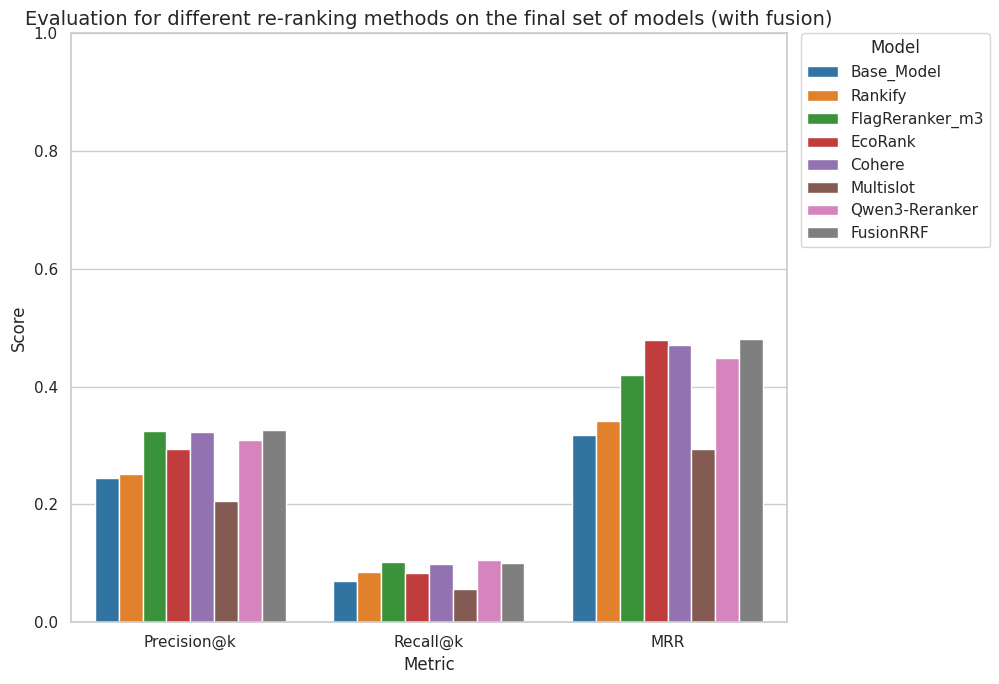

In [ ]:
plot_evaluation_results_extended(final_set_evaluation_results, title="Evaluation for different re-ranking methods on the final set of models (with fusion)")

**Discussion of Initial Evaluation Results**

The general effectiveness of re-ranking is clear, with most methods outperforming the Base_Model. The strong performance of FusionRRF suggests that combining signals from diverse re-rankers is a robust strategy, capable of mitigating the weaknesses of individual models.

Notably, EcoRank's high MRR score combined with its fast speed makes it a standout for practical applications where a balance of cost and performance is crucial. Its two-stage design, using a cheap model to filter before a more expensive one, is validated by these results.

The Multislot reranker performed poorly, even underperforming the baseline model. Its goal is to improve diversity, but its diversity penalty appears to harm relevance more than it helps for this specific dataset. <br>But the Multislot reranker might still be a useful tool providing the LLM model (in the next step) with more a more diverse context for answering a question. This would have to be investigated further and is probably more useful for broader questions than the questions used in this evaluation.

#### Evaluation with improved Fusion

In the previous section the Fusion Reranker used all the other reranking methods as an input. In the following we will use the three of the well performing methods from the the rerankers for the fusion (Cohere, Flag-Reranker and EcoRank). We decided not to include Qwen3-Reranker, since it takes quite long and is computatively demanding.

In [ ]:
def evaluate_models_graded_improved_fusion(Q_A_ground_thruth_relevancy_dict, top_k=10, **retrieval_args):
    # --- Define the methods to evaluate ---
    methods = {
        # Standard Dense + Dense HyDE
        "Base_Model": lambda q: retrieve_no_reranking(q, top_k),
        "FlagReranker_m3": lambda q: flag_reranker_wrapper(q, top_k),
        "EcoRank": lambda q: eco_reranker(q, top_k),
        "Cohere": lambda q: cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
        "Fusion_Flag_EcoRank_Cohere" : lambda q: reciprocal_rank_fusion([
            flag_reranker_wrapper(q, top_k),
            cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
            eco_reranker(q, top_k)])
    }

    scores = {m: {"Precision@k": [], "Recall@k": [], "MRR": []} for m in methods}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        ground_truth_scores = data["ground_truth_relevance"]
        ground_truth_positive_scores = {cid: score for cid, score in ground_truth_scores.items() if score > 0}

        print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")
        if ground_truth_positive_scores:
            print(f"Ground truth scores (>0): {ground_truth_positive_scores}")
        else:
            print("Ground truth scores (>0): {} (No relevant items for this query)")

        all_reranked_dfs = []

        for name, retriever_func in methods.items():
            try:
                retrieved_df = retriever_func(query)
                if retrieved_df is not None and "unique_chunk_id" in retrieved_df.columns and not retrieved_df.empty:
                    retrieved_ids = retrieved_df["unique_chunk_id"].tolist()
                    all_reranked_dfs.append(retrieved_df)

                    print(f" {name}: {len(retrieved_ids)} chunks -> {retrieved_ids[:top_k]}")
                    scores[name]["Precision@k"].append(precision_at_k(retrieved_ids, ground_truth_scores, top_k))
                    scores[name]["Recall@k"].append(recall_at_k(retrieved_ids, ground_truth_scores, top_k))
                    scores[name]["MRR"].append(mrr_graded_cumulative(retrieved_ids, ground_truth_scores))

                else:
                    print(f" {name}: Empty or invalid DataFrame.")
                    scores[name]["Precision@k"].append(0.0)
                    scores[name]["Recall@k"].append(0.0)
                    scores[name]["MRR"].append(0.0)

            except Exception as e:
                print(f" {name}: Error -> {e}")
                # Ensure all metrics are appended with a default value for this method if an error occurs
                scores[name]["Precision@k"].append(0.0)
                scores[name]["Recall@k"].append(0.0)
                scores[name]["MRR"].append(0.0)

    avg_scores = {
        m: {metric: round(np.nanmean(values), 4) if values else 0.0 for metric, values in metrics.items()}
        for m, metrics in scores.items()
    }
    return avg_scores

In [ ]:
evaluation_args_final_set = {
    "cohere_client": co_client,
    "lambda_param": 0.5
}

print("Starting evaluation for the best models and improved fusion")
improved_fusion_eval_results = evaluate_models_graded_improved_fusion(
    Q_A_ground_thruth_relevancy_dict,
    top_k=10,
    **evaluation_args_final_set
)

Starting evaluation for the best models and improved fusion

Q1: Who was president of ETH in 2003?
Ground truth scores (>0): {'4042_15': 0.5, '2259_09': 0.5, '3766_04': 0.5, '3896_00': 0.5, '3968_08': 0.5, '2878_04': 0.5, '3121_01': 0.5, '3481_01': 0.5, '3795_07': 0.5, '1239_13': 0.5, '3429_05': 0.5, '3590_00': 0.5, '2603_02': 0.5, '4183_00': 0.5, '3980_00': 0.5, '3935_04': 0.5, '3805_01': 0.5, '4311_02': 0.5, '3175_04': 0.5, '3804_04': 0.5, '0857_03': 0.5, '3710_01': 0.5, '3510_00': 0.5, '3707_02': 0.5, '2630_02': 0.5, '3127_01': 0.5, '3166_01': 0.5, '3363_02': 0.5, '3795_08': 1.0, '2358_00': 0.5, '3433_00': 0.5, '3947_08': 0.5, '4166_23': 0.5, '2641_00': 0.5, '0241_17': 0.5, '3762_09': 0.5, '3804_01': 0.5, '3429_06': 0.5, '4135_01': 0.5, '4183_04': 0.5, '2814_05': 0.5, '4105_13': 0.5, '3021_09': 0.5, '3466_05': 0.5}
 Base_Model: 10 chunks -> ['3947_09', '2867_01', '0352_05', '2851_04', '3795_08', '4183_05', '3166_08', '2976_00', '3539_14', '0250_09']
 FlagReranker_m3: 10 chunks -> ['

In [ ]:
for model_name, metrics in improved_fusion_eval_results.items():
    print(f"\n{model_name} Evaluation:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Base_Model Evaluation:
  Precision@k: 0.2440
  Recall@k: 0.0696
  MRR: 0.3172

FlagReranker_m3 Evaluation:
  Precision@k: 0.3240
  Recall@k: 0.1016
  MRR: 0.4200

EcoRank Evaluation:
  Precision@k: 0.2940
  Recall@k: 0.0826
  MRR: 0.4791

Cohere Evaluation:
  Precision@k: 0.3220
  Recall@k: 0.0980
  MRR: 0.4700

Fusion_Flag_EcoRank_Cohere Evaluation:
  Precision@k: 0.3320
  Recall@k: 0.1003
  MRR: 0.4600


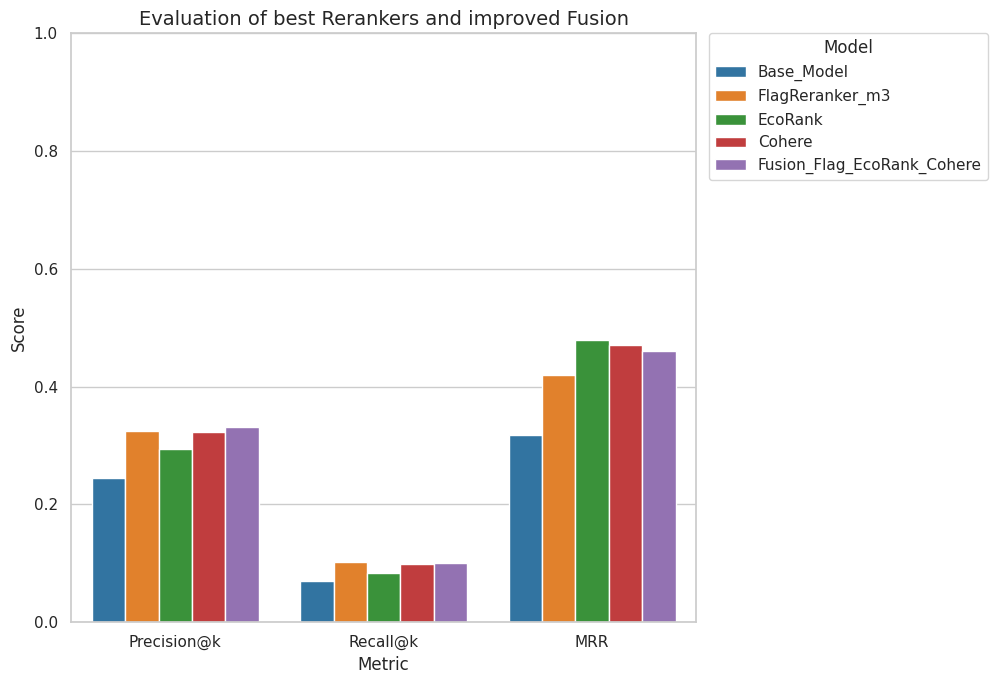

In [ ]:
plot_evaluation_results_extended(improved_fusion_eval_results, title="Evaluation of best Rerankers and improved Fusion")

There is no single best reranking model, but rather multiple high-performing options suited for different priorities. The Fusion strategy proves to be a robust method for maximizing precision and will be our choice to use for proceeding to the next stage.

However, EcoRank's leading MRR score, combined with its exceptional computational efficiency (as detailed in the next section), makes it a compelling choice for practical, low-latency applications where quickly finding the top result is critical. Cohere and FlagReranker are also excellent choices, offering a strong balance of precision and high-quality ranking.

#### Computational Efficiency
This section analyzes the computational efficiency of each re-ranking method against the baseline (no re-ranking), a crucial factor for scalability in production systems. We measured the average, minimum, maximum, and standard deviation of the execution time for each method across all queries. The table below summarizes these timing results in seconds.

It must be noted that the speed for the baseline is just for looking up the top-k chunks in the precalculated dictionary. The determination of the top chunks using the functions used in Section 1.4 takes more time.

We implemented an asynchronous version of the fusion re-ranker. The results confirm that this concurrent approach reduces the total execution time to that of the slowest single method within the fusion, rather than the sum of all three. On the L4 instance (compared to the A100) the gain from using the async function drops.

In [ ]:
async def run_async_fusion(query, top_k, cohere_client):
    # Use asyncio.to_thread to run the original synchronous functions concurrently.
    task_flag = asyncio.to_thread(flag_reranker_wrapper, query, top_k)
    task_cohere = asyncio.to_thread(cohere_reranker, query, top_k, cohere_client=cohere_client)
    task_eco = asyncio.to_thread(eco_reranker, query, top_k)

    # Wait for all thread-based tasks to complete
    results = await asyncio.gather(task_flag, task_cohere, task_eco)

    # Fuse the results using the existing fusion function
    return reciprocal_rank_fusion(results)

In [ ]:
import time
def assess_reranker_efficiency(Q_A_ground_thruth_relevancy_dict, top_k=10, **retrieval_args):
    methods = {
        "Rankify": lambda q: rankify_reranker(q, top_k),
        "FlagReranker_m3": lambda q: flag_reranker_wrapper(q, top_k),
        "EcoRank": lambda q: eco_reranker(q, top_k),
        "Cohere": lambda q: cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
        "Multislot": lambda q: rerank_with_diversity(q, top_k, retrieval_args["lambda_param"]),
        "Qwen3-Reranker": lambda q: qwen_reranker_wrapper(q, top_k),
        "Fusion_Flag_EcoRank_Cohere" : lambda q: reciprocal_rank_fusion([
            flag_reranker_wrapper(q, top_k),
            cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
            eco_reranker(q, top_k)]),
        "Async_Fusion": lambda q: asyncio.run(run_async_fusion(q, top_k, cohere_client=retrieval_args["cohere_client"]))
    }

    timing = {name: [] for name in methods}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        print(f"\n⏱ Measuring time for Q{q_id}: {query[:80]}...")

        for name, func in methods.items():
            try:
                start = time.time()
                _ = func(query)
                duration = time.time() - start
                timing[name].append(duration)
                print(f"  {name}: {duration:.2f} seconds")
            except Exception as e:
                print(f"  {name}: Error → {e}")
                timing[name].append(float('nan'))
            time.sleep(0.5)

    # Create DataFrame with timing statistics
    timing_stats = {
        method: {
            "Avg Time (s)": round(np.nanmean(times), 3),
            "Std Dev": round(np.nanstd(times), 3),
            "Min": round(np.nanmin(times), 3),
            "Max": round(np.nanmax(times), 3)
        }
        for method, times in timing.items()
    }

    timing_df = pd.DataFrame.from_dict(timing_stats, orient='index').sort_values("Avg Time (s)")
    display(timing_df)

    return timing_df


**Times using A100 runtime on Colab**

In [ ]:
evaluation_args_final_set = {
    "cohere_client": co_client,
    "lambda_param": 0.5
}

timing_report = assess_reranker_efficiency(
    Q_A_ground_thruth_relevancy_dict,
    top_k=10,
    **evaluation_args_final_set
)


⏱ Measuring time for Q1: Who was president of ETH in 2003?...
  Rankify: 0.32 seconds
  FlagReranker_m3: 0.23 seconds
  EcoRank: 0.17 seconds
  Cohere: 0.35 seconds
  Multislot: 0.26 seconds
  Qwen3-Reranker: 11.72 seconds
  Fusion_Flag_EcoRank_Cohere: 0.77 seconds
  Async_Fusion: 0.35 seconds

⏱ Measuring time for Q2: Who were the rectors of ETH between 2017 and 2022?...
  Rankify: 0.26 seconds
  FlagReranker_m3: 0.21 seconds
  EcoRank: 0.18 seconds
  Cohere: 0.33 seconds
  Multislot: 0.27 seconds
  Qwen3-Reranker: 11.68 seconds
  Fusion_Flag_EcoRank_Cohere: 0.79 seconds
  Async_Fusion: 0.42 seconds

⏱ Measuring time for Q3: Who at ETH received ERC grants?...
  Rankify: 0.28 seconds
  FlagReranker_m3: 0.23 seconds
  EcoRank: 0.23 seconds
  Cohere: 0.39 seconds
  Multislot: 0.27 seconds
  Qwen3-Reranker: 11.68 seconds
  Fusion_Flag_EcoRank_Cohere: 1.27 seconds
  Async_Fusion: 0.42 seconds

⏱ Measuring time for Q4: When did the InSight get to Mars?...
  Rankify: 0.29 seconds
  FlagRera

,Avg Time (s),Std Dev,Min,Max
EcoRank,0.195,0.023,0.170,0.243
FlagReranker_m3,0.236,0.016,0.213,0.285
Multislot,0.273,0.005,0.264,0.286
Rankify,0.287,0.020,0.263,0.351
Async_Fusion,0.406,0.026,0.351,0.463
Cohere,0.420,0.146,0.278,0.918
Fusion_Flag_EcoRank_Cohere,0.888,0.142,0.739,1.309
Qwen3-Reranker,11.711,0.036,11.660,11.765


**Times using L4 runtime on Colab**

In [ ]:
evaluation_args_final_set = {
    "cohere_client": co_client,
    "lambda_param": 0.5
}

timing_report = assess_reranker_efficiency(
    Q_A_ground_thruth_relevancy_dict,
    top_k=10,
    **evaluation_args_final_set
)


⏱ Measuring time for Q1: Who was president of ETH in 2003?...
  Rankify: 0.62 seconds


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  FlagReranker_m3: 2.56 seconds
  EcoRank: 0.38 seconds
  Cohere: 0.28 seconds
  Multislot: 0.39 seconds
  Qwen3-Reranker: 43.25 seconds
  Fusion_Flag_EcoRank_Cohere: 1.58 seconds
  Async_Fusion: 1.33 seconds

⏱ Measuring time for Q2: Who were the rectors of ETH between 2017 and 2022?...
  Rankify: 0.61 seconds
  FlagReranker_m3: 0.92 seconds
  EcoRank: 0.39 seconds
  Cohere: 0.28 seconds
  Multislot: 0.30 seconds
  Qwen3-Reranker: 43.52 seconds
  Fusion_Flag_EcoRank_Cohere: 1.66 seconds
  Async_Fusion: 1.30 seconds

⏱ Measuring time for Q3: Who at ETH received ERC grants?...
  Rankify: 0.65 seconds
  FlagReranker_m3: 0.98 seconds
  EcoRank: 0.51 seconds
  Cohere: 0.25 seconds
  Multislot: 0.31 seconds
  Qwen3-Reranker: 43.49 seconds
  Fusion_Flag_EcoRank_Cohere: 1.88 seconds
  Async_Fusion: 1.53 seconds

⏱ Measuring time for Q4: When did the InSight get to Mars?...
  Rankify: 0.66 seconds
  FlagReranker_m3: 1.03 seconds
  EcoRank: 0.38 seconds
  Cohere: 0.22 seconds
  Multislot: 0.32 

,Avg Time (s),Std Dev,Min,Max
Cohere,0.293,0.066,0.217,0.545
Multislot,0.319,0.016,0.302,0.388
EcoRank,0.417,0.065,0.356,0.560
Rankify,0.651,0.045,0.586,0.791
FlagReranker_m3,1.058,0.316,0.901,2.563
Async_Fusion,1.437,0.096,1.302,1.626
Fusion_Flag_EcoRank_Cohere,1.739,0.131,1.548,2.054
Qwen3-Reranker,43.458,0.091,43.218,43.561


**Interpretation:**
- Multislot and EcoRank provide a good balance between efficiency and effectiveness, with moderate computational overhead.
- Cohere, FlagReranker_m3, and Rankify are slower, with Rankify being the most computationally intensive among the tested methods.
- Variability (Std Dev) is highest for Cohere, likely due to external API latency.

These results highlight the trade-off between retrieval quality and computational cost. For large-scale or real-time applications, methods closer to the baseline in speed (like Multislot or EcoRank) may be preferable, while more computationally intensive rerankers should be reserved for scenarios where maximum accuracy is required.

**Analysis of Hardware Impact**

Comparing the efficiency results between the NVIDIA A100  and L4  runtimes reveals the significant impact of hardware on model performance. While all models ran slower on the L4 instance, the slowdown was not uniform.

Locally-hosted models like FlagReranker_m3 and especially Qwen3-Reranker saw a dramatic increase in processing time on the L4 GPU. In contrast, API-based models like Cohere exhibited a much less significant change in runtime, as the computational load is handled by an external service.

Furthermore, the benefit of the Async_Fusion method was more pronounced on the A100 GPU, where it was over twice as fast as the sequential fusion. On the L4 GPU, while still faster, the advantage was less dramatic.

**Most Efficient Models**: On the high-end A100 GPU, EcoRank is the fastest model with an average time of 0.195 seconds. On the L4 instance, the API-based Cohere model is the most efficient, averaging just 0.293 seconds, demonstrating the advantage of offloading computation on less powerful hardware. Multislot also proves to be consistently efficient across both platforms.

**Most Computationally Intensive:** Qwen3-Reranker is, by a significant margin, the slowest method on both GPUs, taking over 11 seconds on the A100 and over 43 seconds on the L4. This makes it impractical for most real-time applications despite its strong performance in relevance metrics.

### 2.3 Qualitative Analysis of Reranked Document Alignment

To complement quantitative metrics, we perform a qualitative analysis of the reranked results. This involves manually inspecting the top-ranked documents for each query to assess whether the reranking methods improve contextual alignment and relevance. The goal is to verify that the most relevant documents are surfaced at the top, ensuring that the information provided to the response generation model is both accurate and contextually appropriate.

In [ ]:
def qualitative_ranking_inspection(
    query: str,
    rerankers: dict,
    top_k: int = 5,
    include_ground_truth: dict = None
):

    print(f"\n📌 QUERY: {query}\n{'='*80}")

    for name, reranker_func in rerankers.items():
        try:
            print(f"\n🔍 {name} (Top {top_k}):\n" + "-"*60)
            df = reranker_func(query).head(top_k)

            for i, row in df.iterrows():
                relevance = ""
                if include_ground_truth and row["unique_chunk_id"] in include_ground_truth:
                    score = include_ground_truth[row["unique_chunk_id"]]
                    if score > 0:
                        relevance = f"✅ [GT Score: {score}]"

                print(f"\n{i+1}. {row['title']} {relevance}\n{row['chunk_text'][:500]}...\n")

        except Exception as e:
            print(f"Error in {name}: {e}")


In [ ]:
def qualitative_ranking_inspection(
    query: str,
    rerankers: dict,
    top_k: int = 5,
    include_ground_truth: dict = None
):

    print(f"\n📌 QUERY: {query}\n{'='*80}")

    for name, reranker_func in rerankers.items():
        try:
            print(f"\n🔍 {name} (Top {top_k}):\n" + "-"*60)
            df = reranker_func(query).head(top_k)

            for i, row in df.iterrows():
                relevance = ""
                if include_ground_truth and row["unique_chunk_id"] in include_ground_truth:
                    score = include_ground_truth[row["unique_chunk_id"]]
                    if score > 0:
                        relevance = f"✅ [GT Score: {score}]"

                print(f"\n{i+1}. {row['title']} {relevance}\n{row['chunk_text'][:500]}...\n")

        except Exception as e:
            print(f"Error in {name}: {e}")


Below the `query_id` can be changed to compare the different rerankers on different questions.

In [ ]:
query_id = 6 # Change to the number of the question that you want to inspect
query = Q_A_ground_thruth_relevancy_dict[query_id]["question"]
ground_truth = Q_A_ground_thruth_relevancy_dict[query_id]["ground_truth_relevance"]

top_k = 10
retrieval_args = {
    "cohere_client": co_client,
    "lambda_param": 0.5
}
reranker_functions = {
    "Base_Model": lambda q: retrieve_no_reranking(q, top_k),
    "Rankify": lambda q: rankify_reranker(q, top_k),
    "FlagReranker_m3": lambda q: flag_reranker_wrapper(q, top_k),
    "EcoRank": lambda q: eco_reranker(q, top_k),
    "Cohere": lambda q: cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
    "Multislot": lambda q: rerank_with_diversity(q, top_k, retrieval_args["lambda_param"]),
    "Qwen3-Reranker": lambda q: qwen_reranker_wrapper(q, top_k),
    "Fusion_Flag_EcoRank_Cohere": lambda q: asyncio.run(run_async_fusion(
        q, top_k, cohere_client=retrieval_args["cohere_client"]))
}

qualitative_ranking_inspection(query, reranker_functions, top_k=5, include_ground_truth=ground_truth)



📌 QUERY: What is e-Sling?

🔍 Base_Model (Top 5):
------------------------------------------------------------

1. Carbon tax to finance teaching project 
## Further informationen
1 ETH Zurich’s air travel project. See also this ETH News article Responsible air travel and this blog post No flying for a year
2 external pageAgenda 2030: 17 Sustainable Development Goals.
3 For more on this topic, see this blog post by Christine Bratrich, Head of ETH Sustainability: The 2030 Agenda: Our responsibility as a university and the website ETH Zurich and the Agenda 2030.
4 Within the framework of the focus projects, students independently develop innovative ...


2. Globe eth research supply support to the swiss state 
To investigate what this will mean for the country’s electricity system, the ETH Energy Science Center (ESC) is currently running a project as part of a consortium commissioned by the Swiss Federal Office of Energy (SFOE). ESC researchers point out that all these electric cars will

We observe that while some methods like EcoRank and Cohere consistently surface relevant documents, some questions reveal limitations in retrieved content for some of the methods, where for some methods all chunks appear in the ground truth with high relevance scores, while others have very few or no chunks in the ground truth.

#### Visualization of re-ranked documents vs. ground truth
This heatmap visualizes, for each query and reranker, how many of the top-10 returned chunks are actually relevant according to the ground-truth scoring. Each row corresponds to a query, and each column to a reranking method. Darker blue cells indicate that more relevant chunks were retrieved for that query by the given reranker. This allows quick identification of rerankers that consistently capture (or miss) relevant information across the question set.

In [ ]:
def visualize_reranker_hits_heatmap(
    Q_A_ground_thruth_relevancy_dict,
    reranker_functions: dict,
    top_k: int = 10
):

    match_counts = {name: [] for name in reranker_functions}

    for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
        query = data["question"]
        ground_truth = {cid for cid, score in data["ground_truth_relevance"].items() if score > 0}

        for name, func in reranker_functions.items():
            try:
                df = func(query).head(top_k)
                predicted_ids = set(df["unique_chunk_id"].tolist())
                match = len(predicted_ids & ground_truth)
                match_counts[name].append(match)
            except Exception as e:
                print(f"{name} failed on Q{q_id}: {e}")
                match_counts[name].append(0)

    # Convert to DataFrame (queries as rows, rerankers as columns)
    df_heat = pd.DataFrame(match_counts)
    df_heat.index = [f"Q{qid}" for qid in Q_A_ground_thruth_relevancy_dict.keys()]

    plt.figure(figsize=(12, len(df_heat)*0.5 + 3))
    sns.heatmap(df_heat, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': f'# Relevant Chunks in Top-{top_k}'})
    plt.title(f"Ground Truth Chunk Matches per Query (Top-{top_k} per Reranker)", fontsize=14)
    plt.ylabel("Query")
    plt.xlabel("Reranker")
    plt.tight_layout()
    plt.show()

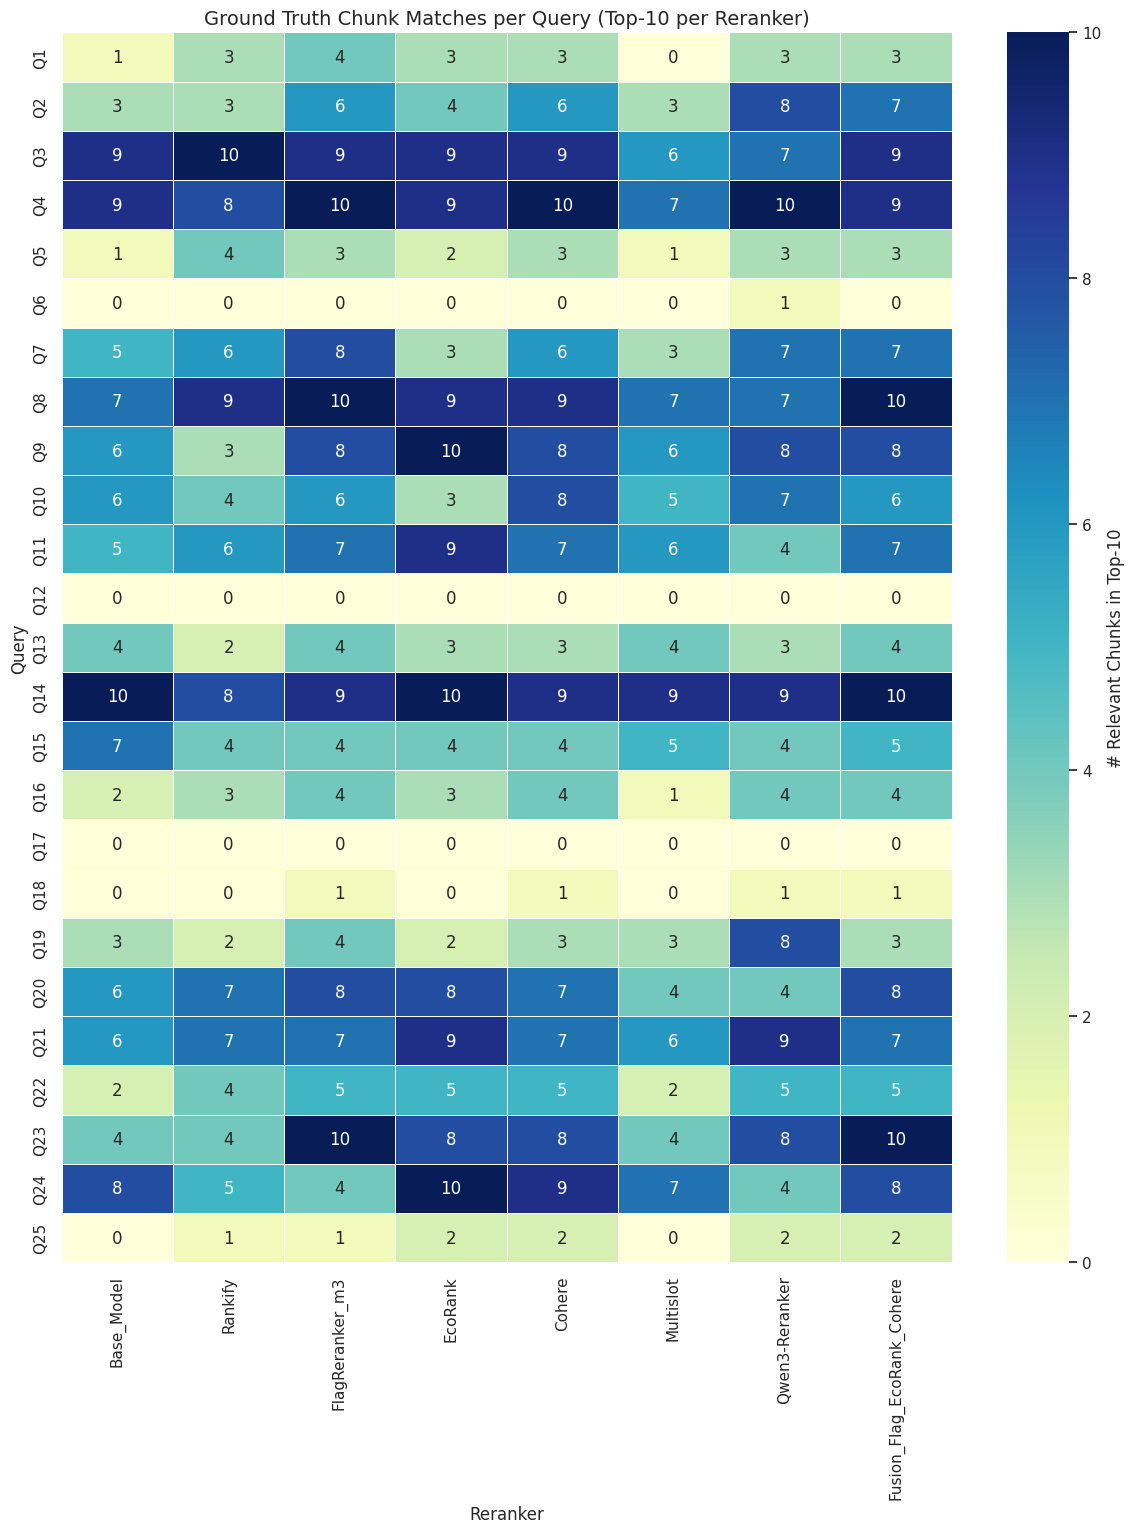

In [ ]:
reranker_functions = {
    "Base_Model": lambda q: retrieve_no_reranking(q, top_k),
    "Rankify": lambda q: rankify_reranker(q, top_k),
    "FlagReranker_m3": lambda q: flag_reranker_wrapper(q, top_k),
    "EcoRank": lambda q: eco_reranker(q, top_k),
    "Cohere": lambda q: cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
    "Multislot": lambda q: rerank_with_diversity(q, top_k, retrieval_args["lambda_param"]),
    "Qwen3-Reranker": lambda q: qwen_reranker_wrapper(q, top_k),
    "Fusion_Flag_EcoRank_Cohere": lambda q: asyncio.run(run_async_fusion(
        q, top_k, cohere_client=retrieval_args["cohere_client"]))
}

visualize_reranker_hits_heatmap(Q_A_ground_thruth_relevancy_dict, reranker_functions, top_k=10)


The results show that FlagReranker_m3, EcoRank, Qwen3-Reranker, Cohere and the Fusion Reranking consistently retrieve relevant chunks for most questions, while the rest show more variability.

Upon further inspection by rows, it is observed that some questions have very few relevant chunks from the re-ranker models in the ground truth, showing some problematic retrieval results for these specific questions. It is possible that the retrieval methods used in the previous step (2.1) did not return enough relevant chunks for these questions or the model failed to retrieve the relevant chunks from the dataset.

Looking at the total score of all chunks in the ground-truth ([See Notebook Stage 2.1](https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/main/2.1_rag_research_agents.ipynb#scrollTo=5Fbc5mAa0N7P&line=6&uniqifier=1)) the critial questions have the following scores:


*   Question 6:  3.0
*   Question 12: 1.0
*   Question 17: 1.0
*   Question 18: 12.0
*   Question 25: 90.5

In [ ]:
# Print Question 6, 12, 17, 18 and 25
for q_id in [6, 12, 17, 18, 25]:
    print(f"Q{q_id}: {Q_A_ground_thruth_relevancy_dict[q_id]['question']}")

Q6: What is e-Sling?
Q12: How much of ETH’s electricity consumption is due to computing? How did that develop over the years?
Q17: How do birds learn new songs?
Q18: What connections does ETH have to Hong Kong?
Q25: Does ETH organize any competitions?


For questions 6, 12 and 17 the low number of relevant chunks gave the retriever and reranking a difficult task to begin with. But for question 18 and 25 it is surprising that only one or two relevant chunks were returned. Let's have a closer look at those two questions.

**Question 18**

Some relevant chunks clearly are not relevant for this question. Some returned chunks are focused on South Korea. This might be due to the generated hypothetical Documents in the HyDE part of the initial Retrieval.

In [ ]:
top_k = 10
retrieval_args = {
    "cohere_client": co_client,
    "lambda_param": 0.5
}
reranker_functions = {
    "Base_Model": lambda q: retrieve_no_reranking(q, top_k),
    "Rankify": lambda q: rankify_reranker(q, top_k),
    "FlagReranker_m3": lambda q: flag_reranker_wrapper(q, top_k),
    "EcoRank": lambda q: eco_reranker(q, top_k),
    "Cohere": lambda q: cohere_reranker(q, top_k, cohere_client=retrieval_args["cohere_client"]),
    "Multislot": lambda q: rerank_with_diversity(q, top_k, retrieval_args["lambda_param"]),
    "Qwen3-Reranker": lambda q: qwen_reranker_wrapper(q, top_k),
    "Fusion_Flag_EcoRank_Cohere": lambda q: asyncio.run(
        run_async_fusion(q, top_k, cohere_client=retrieval_args["cohere_client"]))
}

In [ ]:
query_id = 18
query = Q_A_ground_thruth_relevancy_dict[query_id]["question"]
ground_truth = Q_A_ground_thruth_relevancy_dict[query_id]["ground_truth_relevance"]

qualitative_ranking_inspection(query, reranker_functions, top_k=top_k, include_ground_truth=ground_truth)


📌 QUERY: What connections does ETH have to Hong Kong?

🔍 Base_Model (Top 10):
------------------------------------------------------------

1. 50 million swiss francs for institute of theoretical studies 
ETH Zurich is one of the leading international universities for technology and natural sciences. It is well-known for its excellent education, ground-breaking fundamental research and for putting its new findings directly into practice. Founded in 1855, ETH Zurich today has around 18,000 students from over 100 different countries, 3,800 of whom are doctoral students. It offers researchers an inspiring working environment and its students a comprehensive education. 21 Nobel Laureates have studied...


2. 50 million swiss francs for institute of theoretical studies 
The ETH Zurich Foundation unites companies, private individuals, foundations with ETH Zurich. As the leading technology and science foundation, it supports the university in achieving its most important strategic objectives

**Question 25**

Looking at the top chunks we see one chunk relevant to the question that didn't receive any score in the ground-truth scoring. It is a chunk about the "Chemie olympiade", which would be relevant to the question of "Does ETH organize any competitions?". The scoring was done by an LLM and is of course not perfect. So it might turn out that the question can be answered well with the chunks retrieved.

In [ ]:
query_id = 25
query = Q_A_ground_thruth_relevancy_dict[query_id]["question"]
ground_truth = Q_A_ground_thruth_relevancy_dict[query_id]["ground_truth_relevance"]

qualitative_ranking_inspection(query, reranker_functions, top_k=top_k, include_ground_truth=ground_truth)


📌 QUERY: Does ETH organize any competitions?

🔍 Base_Model (Top 10):
------------------------------------------------------------

1. Anmeldung fuers informatik schnupperstudium jetzt offen 
Die Teilnehmerinnen verbringen drei Tage an der ETH Zürich. In dieser Zeit lernen sie, wie man Android Apps programmiert, erhalten Einblicke in verschiedene Gebiete der Informatik, besuchen Vorlesungen von ETH-Professoren und treffen auf Informatik-Studenten und Studentinnen der ETH Zürich. Zudem erfahren sie bei einer Exkursion in die Industrie mehr über die Karrieremöglichkeiten nach einem erfolgreichen Abschluss des Informatikstudiums.
Das nächste Schnupperstudium findet vom13. bis 15. Februa...


2. 50 million swiss francs for institute of theoretical studies 
ETH Zurich is one of the leading international universities for technology and natural sciences. It is well-known for its excellent education, ground-breaking fundamental research and for putting its new findings directly into practice. 

### 2.4 Conclusion and Preparation for next steps

#### Conclusion of Re-ranking Evaluation

This phase of the project demonstrated the great value of implementing a re-ranking stage within a RAG pipeline. The initial hybrid retrieval method (Base_Model) provided a strong baseline, but our analysis shows that nearly every re-ranking model improved upon it.

The evaluation highlights that there is no single "best" model, but rather a clear trade-off between relevance, performance, and computational cost:

**For Maximum Precision:** <br>The Fusion_Flag_EcoRank_Cohere model, which combines the outputs of three well performing rerankers, achieved the highest Precision@k. This shows that blending diverse, high-quality models is a robust strategy for ensuring the most relevant documents appear in the top results.

**For Optimal Balance of Speed and Performance:** <br>EcoRank stands out as a highly practical choice. It delivered a high Mean Reciprocal Rank (MRR) while also being the fastest model on the A100 GPU. This combination makes it ideal for applications requiring low latency without a significant compromise in quality.

**For Efficiency on less powerful Hardware:** <br>The API-based Cohere model was the fastest on the L4 GPU, illustrating that for less powerful hardware, offloading computation to an external service can be the most efficient option.

**Preparation for Next Steps**<br>
Given its top-tier performance in precision and its robustness from combining multiple models, the Fusion_Flag_EcoRank_Cohere model is the recommended choice to carry forward into the final stage of the RAG pipeline. The successful implementation of an asynchronous fusion method confirms that this approach is computationally viable, mitigating the latency drawback of running multiple models sequentially.

The next step of this project will involve taking the top-k document chunks, re-ranked by our chosen fusion model, and passing them as the final, optimized context to an LLM for answer generation. The high relevance of this context is key to receive the best possible answers by the LLM.

#### Prepare retrieved and reranked chunks for the different questions

We will store the string of the questions as the keys and the returned dataframes from the retrieval + reranking as the corresponding values. With this setup we can utilize the query string in a function input and access the retrieved chunks (arranged in a dataframe) by selecting from the dictionary.

We return the 10 most relevant chunks.

In [ ]:
precalc_reranked_chunks = dict()

In [ ]:
for q_id, data in Q_A_ground_thruth_relevancy_dict.items():
    query = data["question"]

    print(f"\nQ{q_id}: {query[:80]}{'...' if len(query) > 80 else ''}")

    # Step 1: Retrieve an initial set of chunks for the query.
    if query not in precalc_retrieved_chunks:
        raise ValueError(f"Query '{query}' not found in precalculated retrieved chunks.")

    reranked_df = asyncio.run(run_async_fusion(
        query, top_k, cohere_client=co_client))

    reranked_df.reset_index(drop=True, inplace=True)
    display(reranked_df.head(2))
    precalc_reranked_chunks[query] = reranked_df.copy()


Q1: Who was president of ETH in 2003?


,unique_chunk_id,score,chunk_text,title
0,3429_06,0.048395,"The President of the ETH Board, Fritz Schiesse...",New president appointed
1,3795_08,0.047403,"ETH President Ralph Eichler, who is handing ov...",Encouraging more critical opinion



Q2: Who were the rectors of ETH between 2017 and 2022?


,unique_chunk_id,score,chunk_text,title
0,3871_02,0.048916,## Big changes on all study levels\nOver the p...,Eth day 2019
1,2371_01,0.048139,"""I am excited about the opportunity to contrib...",New head of let



Q3: Who at ETH received ERC grants?


,unique_chunk_id,score,chunk_text,title
0,4007_07,0.048916,## Benchmark for top researchers: ERC Grants\n...,Two advanced grants for eth
1,3509_00,0.045295,ERC Advanced Grants are very popular among res...,Seven eth researchers awarded grants



Q4: When did the InSight get to Mars?


,unique_chunk_id,score,chunk_text,title
0,4323_00,0.046642,## InSight mission\nInSight (Interior Explorat...,What seismic waves reveal about martian crust
1,3913_02,0.046460,"## Measurements on Mars\nOn 26 November 2018, ...",Other worlds



Q5: What did Prof. Schubert say about ﬂying?


,unique_chunk_id,score,chunk_text,title
0,3420_05,0.048660,## Setting price signals\nIf we want to reduce...,Blog kosten fliegen renate schubert
1,0526_05,0.048387,## Preissignale und Zeichen setzen\nWill man d...,Blog kosten fliegen renate schubert



Q6: What is e-Sling?


,unique_chunk_id,score,chunk_text,title
0,2944_14,0.047938,## What is E-Periodica?\nexternal pageE-Period...,Neu digitalisierte zeitschriften auf e periodica
1,1248_03,0.044136,## Energie und Nachhaltigkeit\nElektrofahrzeug...,Eth zuerich heisst die industrie willkommen



Q7: Who are famous ETH alumni?


,unique_chunk_id,score,chunk_text,title
0,3166_08,0.046006,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...
1,0131_00,0.031754,Die ETH Zürich hat seit ihren Anfängen grosse ...,50 millionen spende fuer institut fuer theoret...



Q8: Who at ETH currently works on research regarding climate change?


,unique_chunk_id,score,chunk_text,title
0,4166_12,0.046724,## Award of the title of “Professor”\n(Photogr...,New appointments at eth zurich
1,3237_09,0.045715,"## Your experience is valuable\nOn Wednesday, ...",Blog grote working from home



Q9: How do alpine plants respond to climate change?


,unique_chunk_id,score,chunk_text,title
0,3332_04,0.048916,"""Immigrant herbivores consume specific plants ...",How climate change is disrupting ecosystems
1,4291_02,0.047891,Alexander parks the car and heads uphill to a ...,Globe alpine plants respond to climate change



Q10: How would you make fertilizer without carbon emissions?


,unique_chunk_id,score,chunk_text,title
0,4342_00,0.048660,Intensive agriculture is possible only if the ...,Producing fertiliser without carbon emissions
1,3797_00,0.046751,When fossil fuels are burned at high temperatu...,Nitrogen build up in the oceans



Q11: What research is ETH famous for?


,unique_chunk_id,score,chunk_text,title
0,3166_08,0.048660,ETH Zurich is one of the leading international...,50 million swiss francs for institute of theor...
1,4089_06,0.047183,ETH Zurich is among the world’s leading educat...,First time in switzerland the 55th chemistry o...



Q12: How much of ETH’s electricity consumption is due to computing? How did that deve...


,unique_chunk_id,score,chunk_text,title
0,2988_03,0.049180,"For this reason, ETH Zurich is aiming to save ...",Die eth zuerich setzt sich fuer 2023 ein energ...
1,2988_05,0.048131,Since ETH has already bought 67 percent of its...,Die eth zuerich setzt sich fuer 2023 ein energ...



Q13: What are pseudocereals and who does research on them?


,unique_chunk_id,score,chunk_text,title
0,3575_03,0.049180,## A plea for pseudocereals\nThe three most im...,More variety eat buckwheat
1,3575_02,0.048387,## Competition for the traditional calorie sup...,More variety eat buckwheat



Q14: Who is working on methods for targeted cancer treatment, and what do they use?


,unique_chunk_id,score,chunk_text,title
0,4290_01,0.048916,"Alongside Richter, postdoc Edgars Lakis and ET...",Protein scissors for more effective cancer tre...
1,4290_02,0.048395,## Drugs that target cancer more effectively\n...,Protein scissors for more effective cancer tre...



Q15: How is ETH research investigating methods to avoid diarrhea?


,unique_chunk_id,score,chunk_text,title
0,3191_12,0.049180,"For instance, Lacroix teamed up with Michael Z...",Focus food in lieu of pills
1,4171_05,0.046679,## A robust network in Basel\nETH researchers ...,Press release new teaching and research facili...



Q16: What is ETH Plus?


,unique_chunk_id,score,chunk_text,title
0,3877_01,0.048916,“I think it’s fantastic that so many members o...,Eth plus initiatives
1,3816_08,0.047891,## Enabling innovation: ETH+ Grants\nThe ETH+ ...,Eth zurich promotes data science research



Q17: How do birds learn new songs?


,unique_chunk_id,score,chunk_text,title
0,4243_07,0.049180,"## Learning from bird songs\nHowever, the algo...",Ai listens to the sound of healthy machines
1,3701_04,0.047627,"## Birds a special case\nInterestingly, at fir...",Impact of selective logging in tropical forest...



Q18: What connections does ETH have to Hong Kong?


,unique_chunk_id,score,chunk_text,title
0,2380_05,0.048660,## Focus on long-term solutions\nETH Zurich wo...,More buses to hoenggerberg campus
1,4122_06,0.046898,## ETH Zurich and the Republic of Korea\nETH Z...,Visit of the president of the republic of kore...



Q19: For how many years has ETH done research on Quantum Computing?


,unique_chunk_id,score,chunk_text,title
0,3427_01,0.048652,. “We are therefore all the more delighted tha...,Quantum flagship
1,3997_10,0.048147,. ETH also joined forces with PSI to back the ...,Interview wallraff wood



Q20: What are the current projections for the student numbers at ETH?


,unique_chunk_id,score,chunk_text,title
0,4055_00,0.048916,"A total of around 25,000 students and doctoral...",Eth continues to grow
1,4190_03,0.048147,## Federal financial contribution fails to kee...,Press release financial uncertainty threatens ...



Q21: Why should I study at ETH?


,unique_chunk_id,score,chunk_text,title
0,2271_03,0.048916,- Quality and excellence: ETH should aim to at...,The executive board reports 2019 5
1,2984_07,0.048652,Why is that?\n Many students at ETH have taken...,Seeking help with mental health problems is a ...



Q22: Who investigated the catastrophic events in Tibet in 2016, and what was found?


,unique_chunk_id,score,chunk_text,title
0,3144_00,0.049180,"On 17 July 2016, a glacier near the Aru Co Lak...",Twin glacier collapse in tibet
1,0870_00,0.048131,Am 17. Juli 2016 kollabierte ein Gletscher nah...,Doppelter gletscherkollaps in tibet



Q23: Why should ETH receive any additional funding?


,unique_chunk_id,score,chunk_text,title
0,2499_04,0.048916,«Transparency in departmental governance» is p...,A final recommendation
1,2499_07,0.047139,I make these recommendations in the interest o...,A final recommendation



Q24: Anybody at ETH doing anything for people with disabilities?


,unique_chunk_id,score,chunk_text,title
0,2997_04,0.048916,## Barrier-free at ETH Zurich\nETH Zurich is c...,Barrier free eth a change of perspective
1,3005_05,0.047883,## Barrier-free at ETH Zurich\nETH Zurich is c...,Accessibility at eth design for%20all campaign



Q25: Does ETH organize any competitions?


,unique_chunk_id,score,chunk_text,title
0,4089_02,0.048412,ETH Zurich has been busy with preparations for...,First time in switzerland the 55th chemistry o...
1,3318_00,0.047387,"Since 2008, the ETH Zurich Executive Board has...",Two additional vice presidents


In [ ]:
# Save dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-02-precalc-reranked-chunks.pkl")
with open(filename, 'wb') as f:
    pickle.dump(precalc_reranked_chunks, f)

print(f"Dictionary saved to {filename}")

Dictionary saved to /content/drive/MyDrive/AdvGenAI/Stage3/Working-dir/Stage3-02-precalc-reranked-chunks.pkl


In [12]:
# Load dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-02-precalc-reranked-chunks.pkl")
with open(filename, 'rb') as f:
    precalc_reranked_chunks = pickle.load(f)
print(f"Dictionary loaded from {filename}:")

Dictionary loaded from /content/drive/MyDrive/AdvGenAI/Stage3/Working-dir/Stage3-02-precalc-reranked-chunks.pkl:


#### Saving dataset

Additionally we save the information in the `precalc_reranked_chunks` to a JSON file in the `Final-Datasets` folder.

In [14]:
# Convert the DataFrames in the dictionary to a JSON-friendly format.
json_serializable_chunks = {
    query: df.to_dict('records')
    for query, df in precalc_reranked_chunks.items()
}

json_filename = os.path.join(base_folder, "Stage3/Final-Datasets/Stage3-precalc-reranked-chunks.json")
with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(json_serializable_chunks, f, indent=4)

print(f"Dictionary saved to {json_filename}")

Dictionary saved to /content/drive/MyDrive/AdvGenAI/Stage3/Final-Datasets/Stage3-precalc-reranked-chunks.json
